In [ ]:
import torch.cuda
torch.cuda.empty_cache()
import pytorch_lightning as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, pickle, warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

from sklearn.metrics import mean_absolute_error
import holidays
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
import gc



In [3]:

# Login using e.g. `huggingface-cli login` to access this dataset
df = pd.read_parquet("hf://datasets/SamuelM0422/Hourly-Electricity-Demand-Brazil-Dataset/data/train-00000-of-00001.parquet")

In [4]:
df.head(100)

id_subsistema nom_subsistema        din_instante  val_cargaenergiahomwmed
0              N          NORTE 2020-01-01 00:00:00                4889.1460
1             NE       NORDESTE 2020-01-01 00:00:00                9617.9750
2              S            SUL 2020-01-01 00:00:00               10013.7420
3             SE        SUDESTE 2020-01-01 00:00:00               33108.8615
4              N          NORTE 2020-01-01 01:00:00                4953.3150
..           ...            ...                 ...                      ...
95            SE        SUDESTE 2020-01-01 23:00:00               37077.1445
96             N          NORTE 2020-01-02 00:00:00                5350.9790
97            NE       NORDESTE 2020-01-02 00:00:00               10079.1960
98             S            SUL 2020-01-02 00:00:00               10371.5310
99            SE        SUDESTE 2020-01-02 00:00:00               35407.1530

[100 rows x 4 columns]

In [5]:
df.shape

(185280, 4)

In [6]:
df.columns

Index(['id_subsistema', 'nom_subsistema', 'din_instante',
       'val_cargaenergiahomwmed'],
      dtype='object')

find sampling rate

In [3]:
from datetime import date
import pandas as pd


count_2020 = df[pd.to_datetime(df['din_instante']).dt.year == 2020].shape[0]
print(f"Number of rows for year 2020: {count_2020}")
n_samples_hour=count_2020/365/24
print(f"Number of samples per hour: {n_samples_hour}")

Number of rows for year 2020: 35136
Number of samples per hour: 4.0109589041095886


down sample for 1 sample per day using mean for better visualization

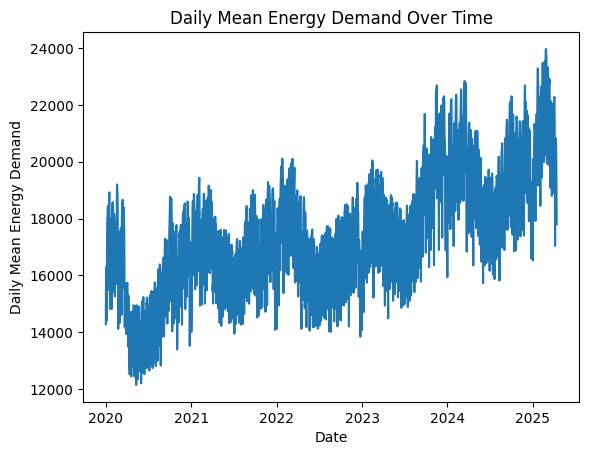

In [8]:

df_copy = df.copy()
df_copy['din_instante'] = pd.to_datetime(df_copy['din_instante'])
df_copy = df_copy.set_index('din_instante')
df_resampled = df_copy.resample("D").mean(numeric_only=True)
plt.plot(df_resampled.index, df_resampled["val_cargaenergiahomwmed"])
plt.xlabel('Date')
plt.ylabel('Daily Mean Energy Demand')
plt.title('Daily Mean Energy Demand Over Time')
plt.show()

visualize demand per year

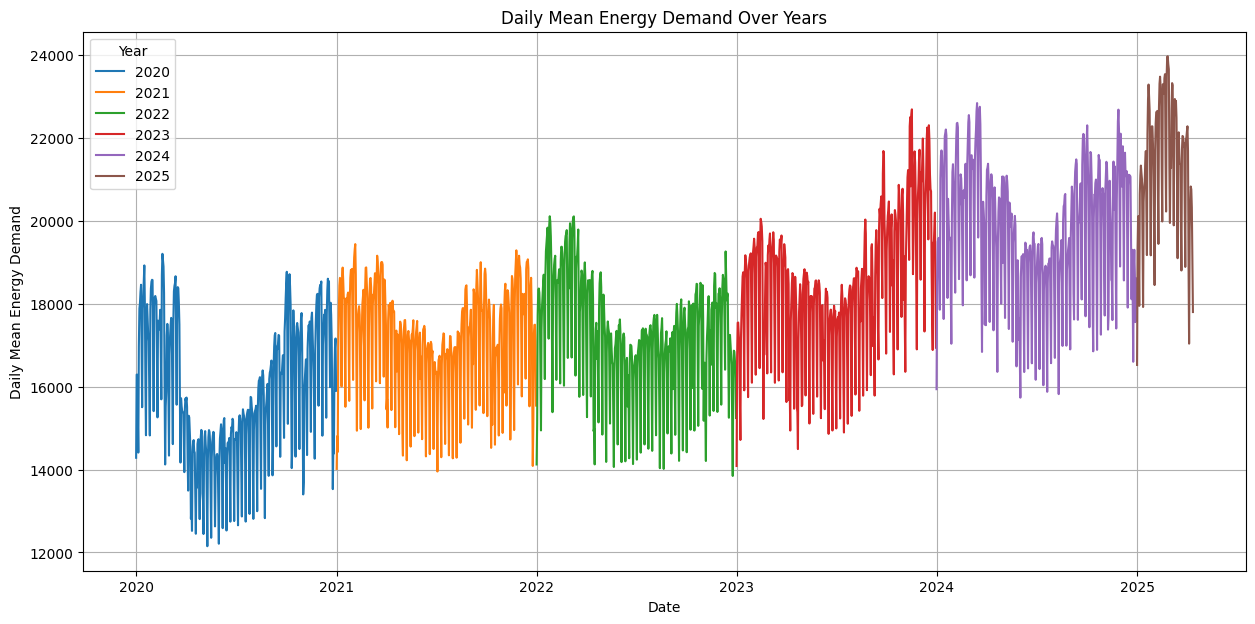

In [9]:
import matplotlib.pyplot as plt

years = [2020, 2021, 2022, 2023, 2024, 2025]
plt.figure(figsize=(15, 7))

for year in years:
  df_resampled_year = df_resampled[df_resampled.index.year == year]
  plt.plot(df_resampled_year.index, df_resampled_year["val_cargaenergiahomwmed"], label=str(year))

plt.xlabel('Date')
plt.ylabel('Daily Mean Energy Demand')
plt.title('Daily Mean Energy Demand Over Years')
plt.legend(title='Year')
plt.grid(True)
plt.show()

visualize demand for each year sepratly

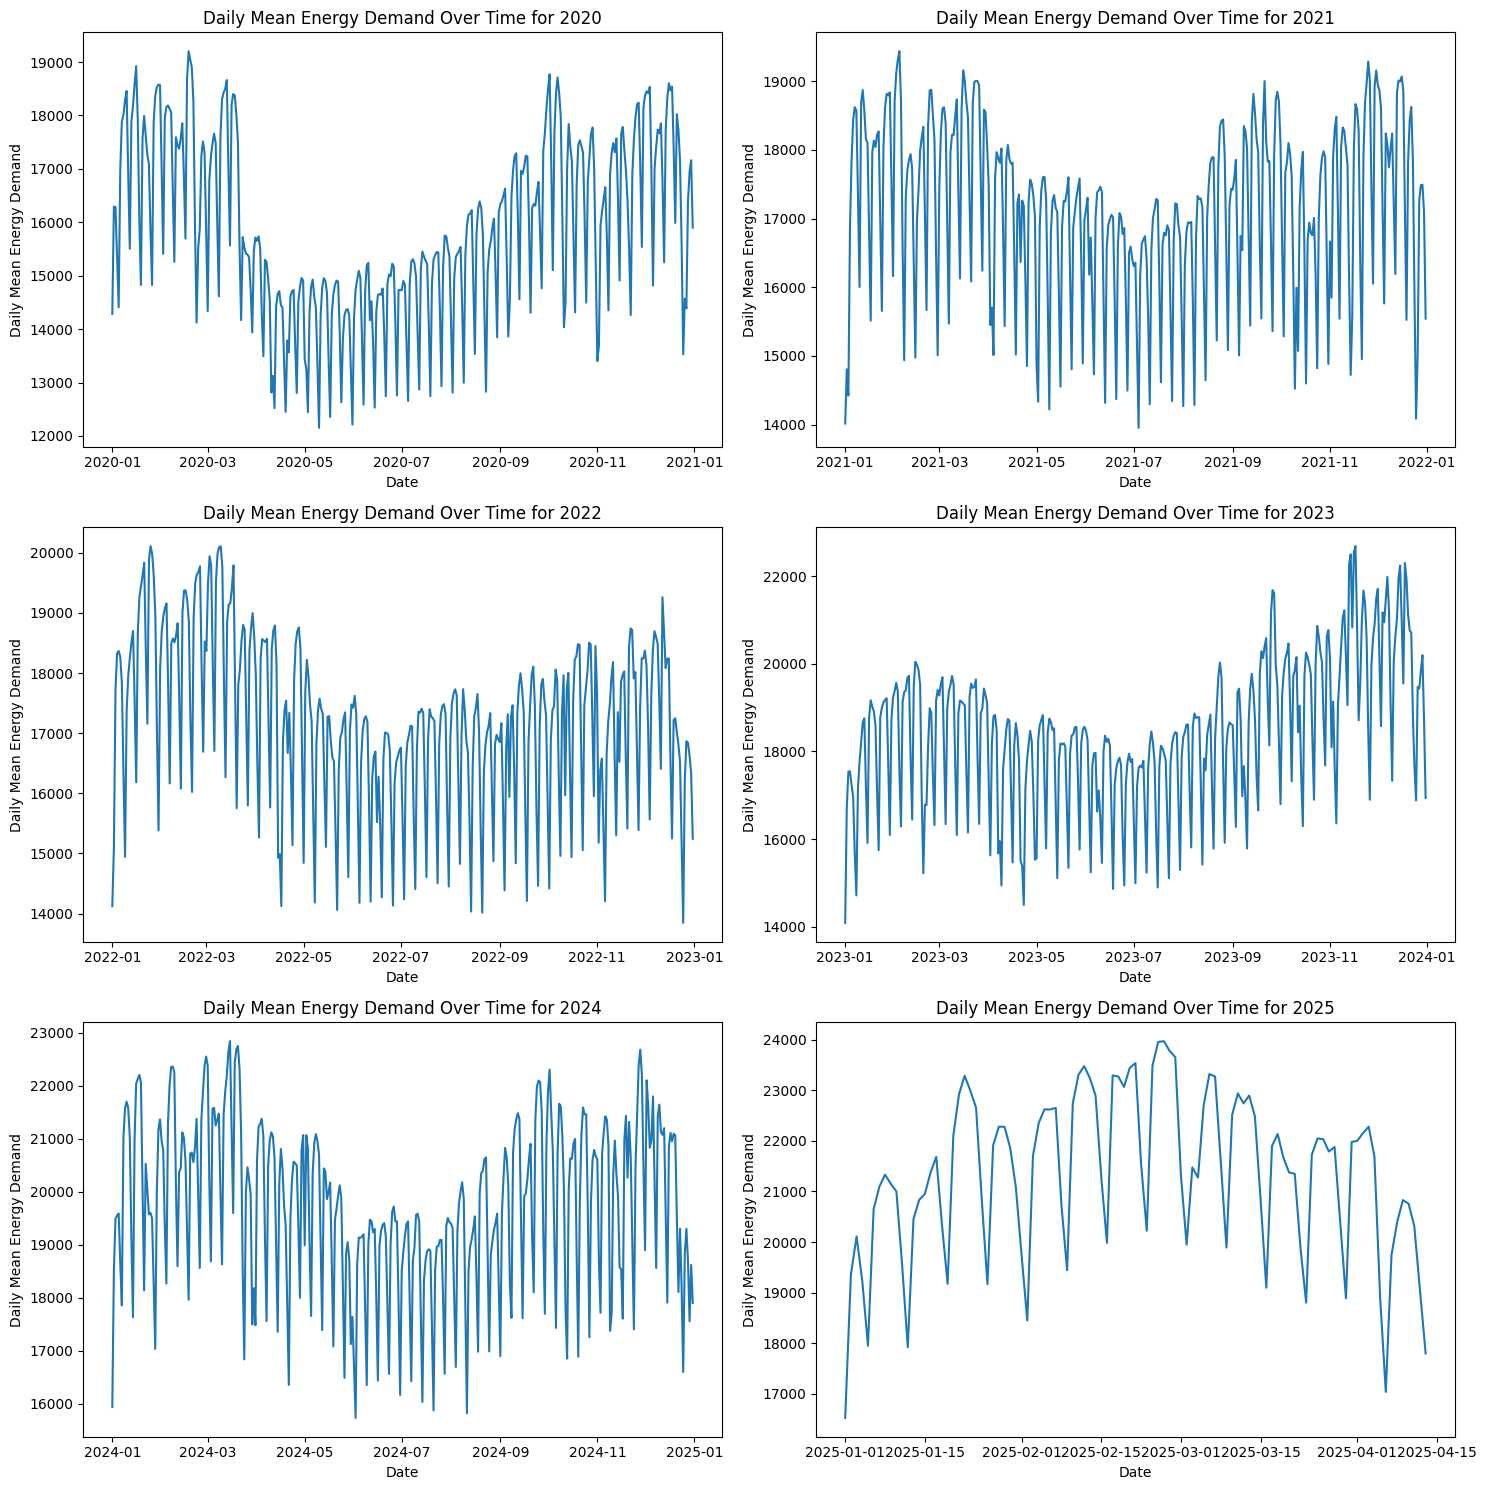

In [10]:
num_years = len(years)

nrows = (num_years + 1) // 2
ncols = 2


fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for i, year in enumerate(years):
  ax = axes[i]
  df_resampled_year = df_resampled[df_resampled.index.year == year]
  ax.plot(df_resampled_year.index, df_resampled_year["val_cargaenergiahomwmed"])
  ax.set_xlabel('Date')
  ax.set_ylabel('Daily Mean Energy Demand')
  ax.set_title(f'Daily Mean Energy Demand Over Time for {year}')


for j in range(num_years, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

visualize demand for each region

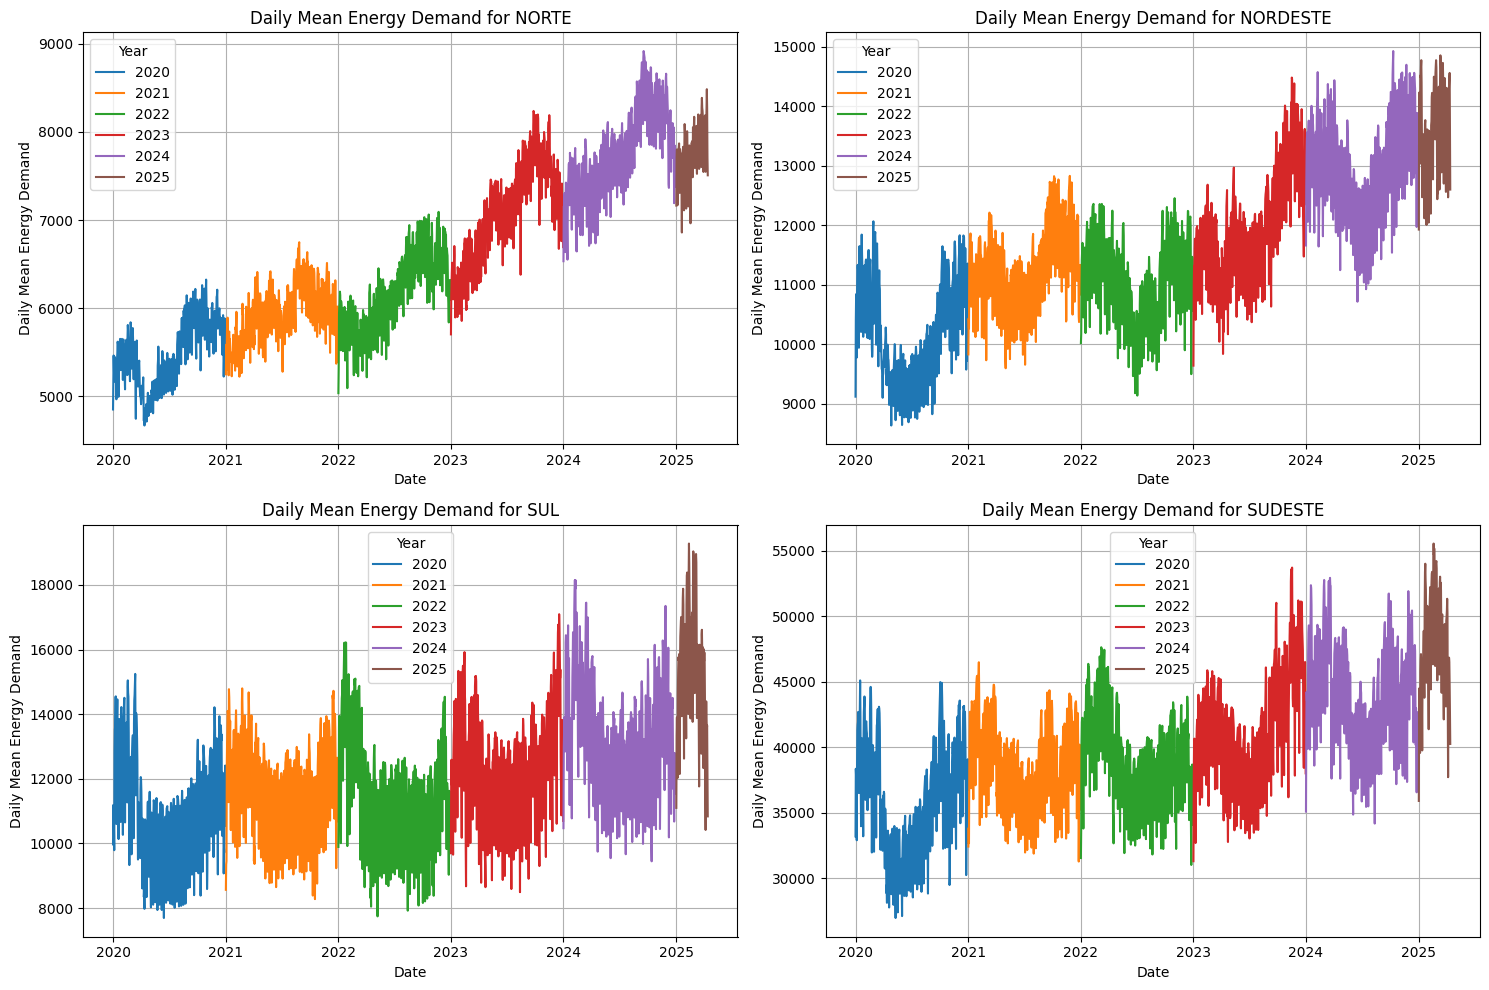

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_processed = df.copy()
df_processed['din_instante'] = pd.to_datetime(df_processed['din_instante'])

sub_sys_names = df_processed['nom_subsistema'].unique()
n_subsys = len(sub_sys_names)

nrows = (n_subsys + 1) // 2
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

years = sorted(df_processed['din_instante'].dt.year.unique())

for i, subsistema_name in enumerate(sub_sys_names):
  ax = axes[i]
  df_subsystem = df_processed[df_processed['nom_subsistema'] == subsistema_name].copy()

  df_subsystem = df_subsystem.set_index('din_instante')

  df_resampled_subsystem = df_subsystem.resample("D").mean(numeric_only=True)

  for year in years:
    df_resampled_year_subsystem = df_resampled_subsystem[df_resampled_subsystem.index.year == year]
    ax.plot(df_resampled_year_subsystem.index, df_resampled_year_subsystem["val_cargaenergiahomwmed"], label=str(year))

  ax.set_xlabel('Date')
  ax.set_ylabel('Daily Mean Energy Demand')
  ax.set_title(f'Daily Mean Energy Demand for {subsistema_name}')
  ax.legend(title='Year')
  ax.grid(True)

for j in range(n_subsys, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**observations**

data seasonality and trend line is changing during the years but still looks the same over the years , seasonal in almost the same pattern and increasing trend


In [13]:
df['val_cargaenergiahomwmed'].isna().sum() ##no missing data

np.int64(0)

In [14]:
df.duplicated().sum() ##no duplicated data

np.int64(0)

## prepocessing

**outlier handling**

checking for outliers then checking for seasonal pattern and holidays so we don't remove representitive data

In [4]:

def brazil_outlier_pipeline(series, holiday_dates=None,
                                   rolling_window=96, z_thresh=4.0,
                                   plateau_frac=0.6, max_pct_jump=50.0,
                                   fix_methods=None, classes_to_fix=('glitch','corruption','unknown')):
    """
    Input: a pandas Series indexed by hourly timestamp (single region)
    Returns: cleaned_series, audit_df
    """
    s = series.copy().sort_index()
    # 1) fill small gaps first for stable z-score
    s = s.interpolate(method='time', limit=6, limit_direction='both').ffill().bfill()
    # detect z-score outliers
    rolling_mean = s.rolling(rolling_window, min_periods=1, center=True).mean()
    rolling_std  = s.rolling(rolling_window, min_periods=1, center=True).std().replace(0, np.nan)
    z = (s - rolling_mean) / rolling_std
    out_mask = z.abs() > z_thresh
    out_idx = np.where(out_mask)[0]

    # heuristics for classification
    details = []
    for idx in out_idx:
        ts = s.index[idx]
        val = s.iloc[idx]
        # neighborhood
        win = 4
        left = max(0, idx-win)
        right = min(len(s), idx+win+1)
        seg = s.iloc[left:right]
        # holiday check
        if holiday_dates is not None and pd.to_datetime(ts).normalize() in set(pd.to_datetime(holiday_dates).normalize()):
            cls = 'holiday'
        elif len(seg) > 1 and (seg == seg.iloc[0]).sum() / len(seg) >= plateau_frac:
            cls = 'corruption'
        else:
            local_med = seg.median()
            prev_val = s.iloc[idx-1] if idx-1 >= 0 else local_med
            next_val = s.iloc[idx+1] if idx+1 < len(s) else local_med
            pct = abs(val - (local_med if local_med != 0 else 1))/ (abs(local_med) if local_med!=0 else 1) * 100
            if pct > max_pct_jump and (abs(val-prev_val) > local_med*0.5 or abs(val-next_val) > local_med*0.5):
                cls = 'glitch'
            else:
                # seasonal heuristic: check same hour previous day/week
                similar = 0; checks = 0
                for lag in [24*4,168*4]:
                    if idx-lag >= 0:
                        checks += 1
                        if s.iloc[idx-lag] > s.median()*1.1:
                            similar += 1
                if checks > 0 and similar / checks >= 0.5:
                    cls = 'seasonal'
                else:
                    cls = 'unknown'
        details.append({'timestamp': ts, 'index': idx, 'original': val, 'z': float(z.iloc[idx]), 'class': cls})

    details_df = pd.DataFrame(details)
    # If details_df is empty (no outliers found), initialize it with expected columns for the merge to work
    if details_df.empty and not details:
        details_df = pd.DataFrame(columns=['timestamp', 'index', 'original', 'z', 'class'])

    # default fix methods
    if fix_methods is None:
        fix_methods = {'glitch':'interpolate', 'corruption':'ffill', 'unknown':'rolling_median','seasonal':'keep','holiday':'keep'}

    s_fixed = s.copy()
    handled = []
    for r in details:
        idx = int(r['index']); cls = r['class']; action = fix_methods.get(cls, 'rolling_median')
        orig = r['original']
        applied = 'none'
        if (cls in classes_to_fix) or (action != 'keep'):
            if action == 'interpolate':
                s_fixed.iloc[idx] = np.nan
                applied = 'interpolate'
            elif action == 'rolling_median':
                med = s.rolling(13, min_periods=1, center=True).median().iloc[idx]
                s_fixed.iloc[idx] = med
                applied = 'rolling_median'
            elif action == 'ffill':
                if idx-1 >= 0: s_fixed.iloc[idx] = s_fixed.iloc[idx-1]
                else: s_fixed.iloc[idx] = s.median()
                applied = 'ffill'
            elif action == 'keep':
                applied = 'keep'
        handled.append({'timestamp': r['timestamp'], 'index': idx, 'original': orig, 'class': cls, 'action': action, 'applied': applied})

    handled_df = pd.DataFrame(handled)
    # If handled_df is empty (no outliers found), initialize it with expected columns
    if handled_df.empty and not handled:
        handled_df = pd.DataFrame(columns=['timestamp', 'index', 'original', 'class', 'action', 'applied'])

    # finalize interpolation for any NaNs
    if s_fixed.isna().any():
        s_fixed = s_fixed.interpolate(method='time', limit_direction='both').ffill().bfill()

    required_cols_for_merge = ['index','action','applied']
    audit = details_df.merge(handled_df[required_cols_for_merge], on='index', how='left')
    return s_fixed, audit,details_df

In [5]:
years = range(2020, 2026) 

# Get Brazilian holidays for the specified years
br_holidays = holidays.Brazil(years=years)

# Convert to a list of datetime.date objects for easy use
holiday_dates_list = [date for date in br_holidays]

In [ ]:
df_cleaned_list = []
sub_sys_names = df['nom_subsistema'].unique()

for subsistema_name in sub_sys_names:
    df_subsystem = df[df['nom_subsistema'] == subsistema_name].copy()
    df_subsystem['din_instante'] = pd.to_datetime(df_subsystem['din_instante'])
    df_subsystem = df_subsystem.set_index('din_instante').sort_index()

    # Apply the outlier detection and fixing pipeline, passing the holiday dates
    cleaned_series, audit_df ,details_df= brazil_outlier_pipeline(df_subsystem['val_cargaenergiahomwmed'], holiday_dates=holiday_dates_list,z_thresh=2.0)

    # Create a new DataFrame for the cleaned data of this subsystem
    df_subsystem_cleaned = df_subsystem.copy()
    df_subsystem_cleaned['val_cargaenergiahomwmed_cleaned'] = cleaned_series

    df_cleaned_list.append(df_subsystem_cleaned.reset_index())

df_cleaned = pd.concat(df_cleaned_list, ignore_index=True)

print("Original vs. Cleaned data sample:")
print(df_cleaned[['din_instante', 'nom_subsistema', 'val_cargaenergiahomwmed', 'val_cargaenergiahomwmed_cleaned']].head())

Original vs. Cleaned data sample:
         din_instante nom_subsistema  val_cargaenergiahomwmed  \
0 2020-01-01 00:00:00          NORTE                 4889.146   
1 2020-01-01 01:00:00          NORTE                 4953.315   
2 2020-01-01 02:00:00          NORTE                 4992.290   
3 2020-01-01 03:00:00          NORTE                 5005.238   
4 2020-01-01 04:00:00          NORTE                 5006.650   

   val_cargaenergiahomwmed_cleaned  
0                         4889.146  
1                         4953.315  
2                         4992.290  
3                         5005.238  
4                         5006.650  


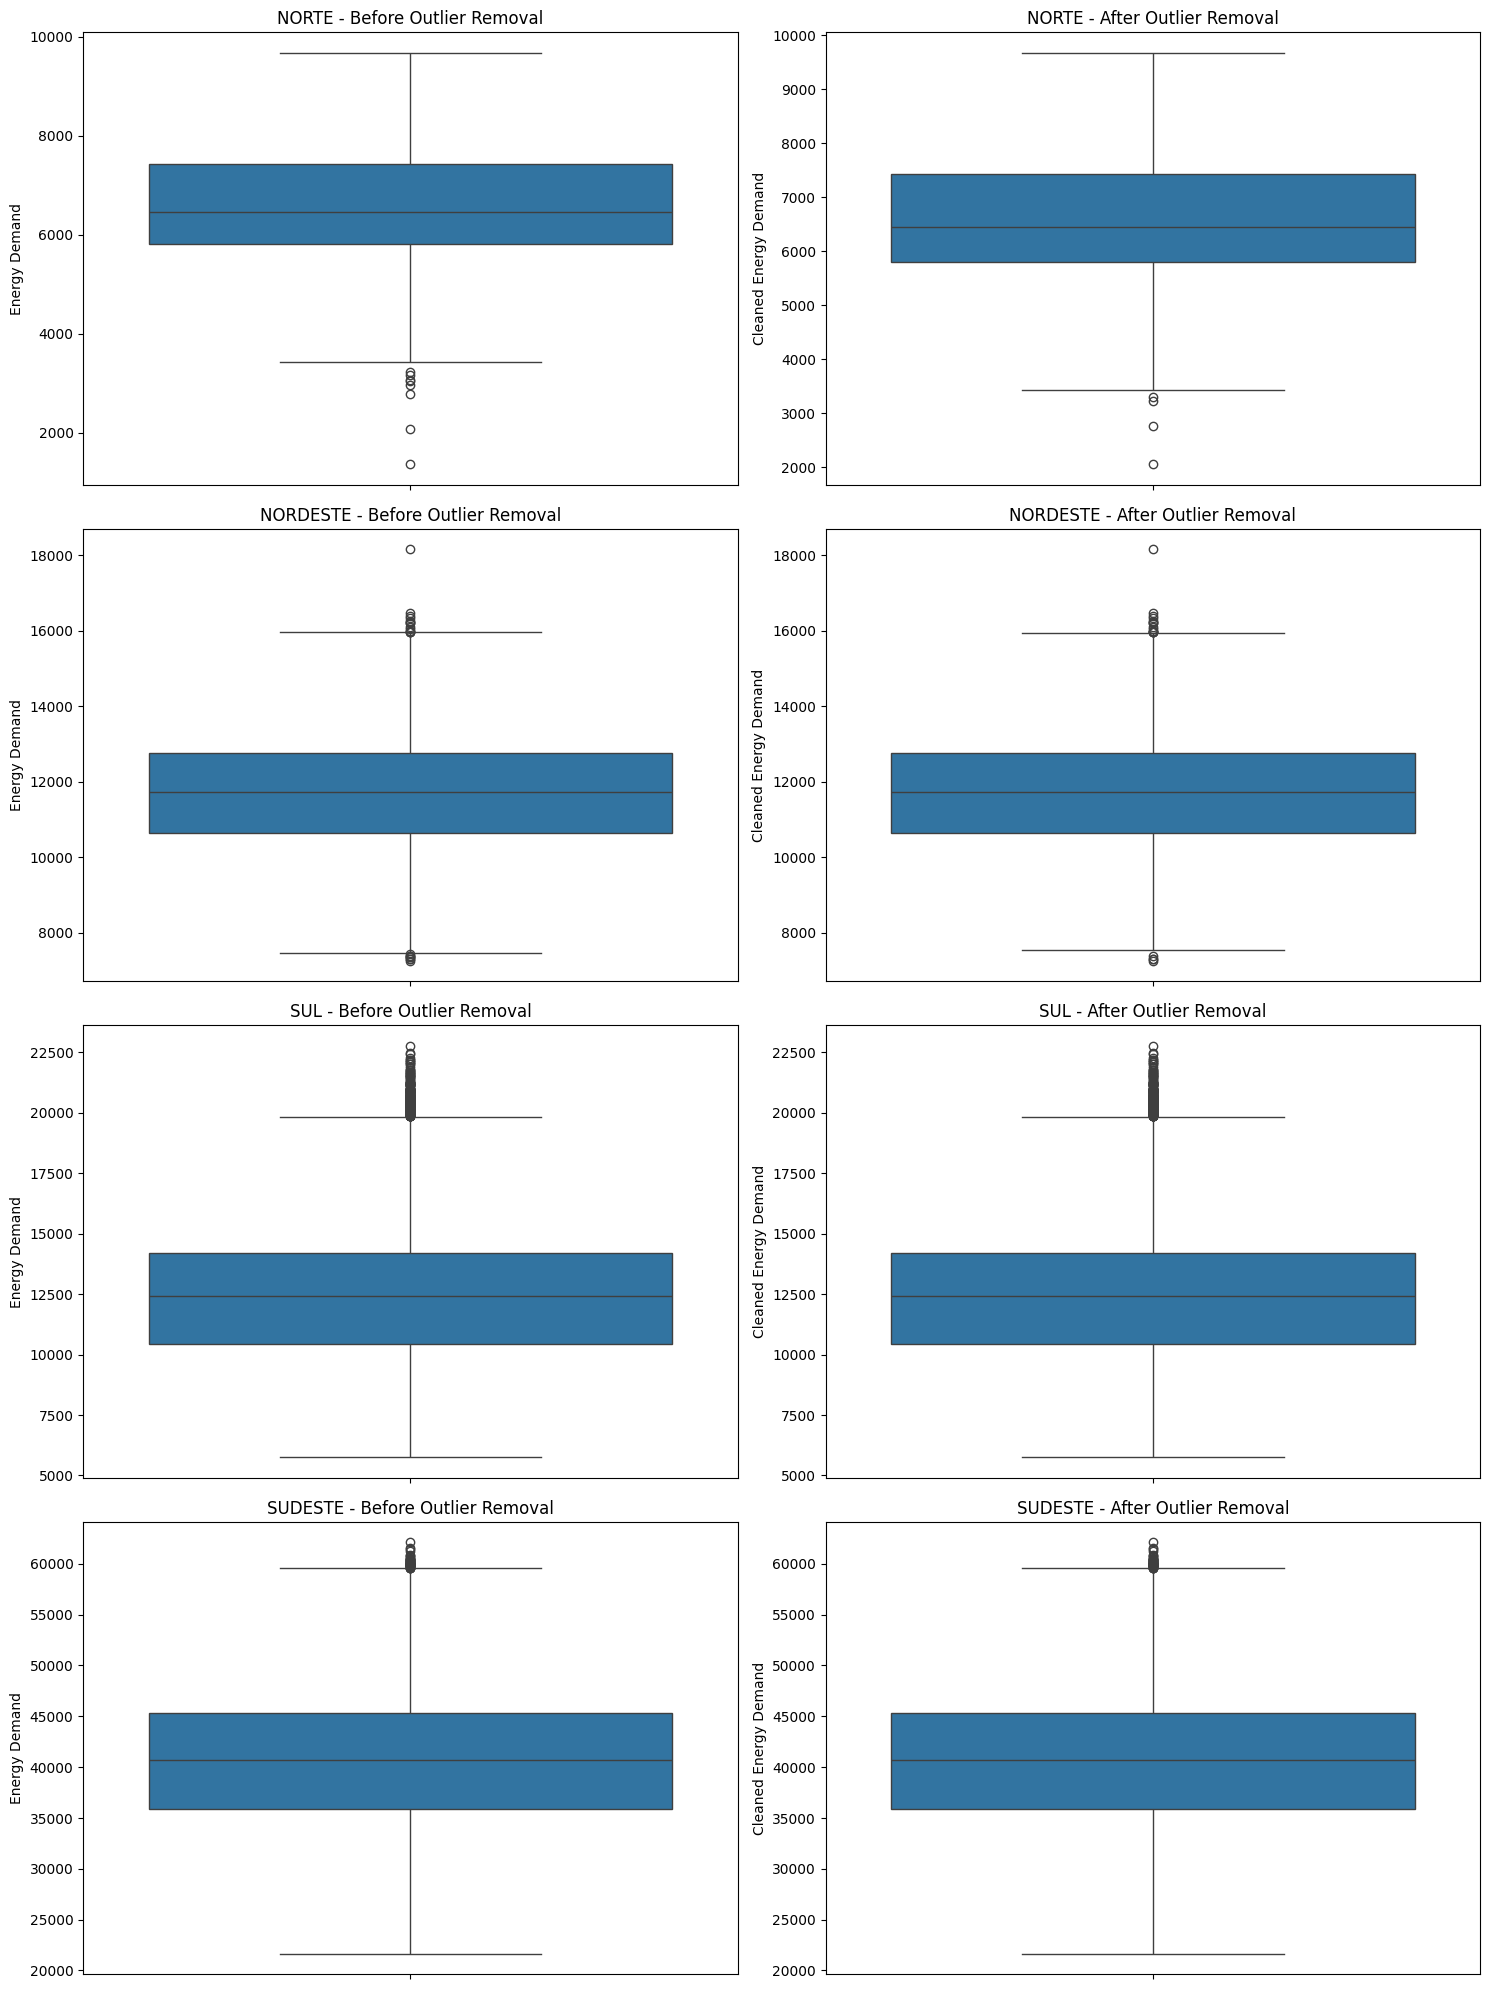

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sub_sys_names = df_cleaned['nom_subsistema'].unique()
n_subsys = len(sub_sys_names)

fig, axes = plt.subplots(nrows=n_subsys, ncols=2, figsize=(15, 5 * n_subsys), sharey=False)

for i, subsistema_name in enumerate(sub_sys_names):
    df_subsystem = df_cleaned[df_cleaned['nom_subsistema'] == subsistema_name]

    # Plot 'before' outlier removal
    ax_before = axes[i, 0]
    sns.boxplot(y=df_subsystem['val_cargaenergiahomwmed'], ax=ax_before)
    ax_before.set_title(f'{subsistema_name} - Before Outlier Removal')
    ax_before.set_ylabel('Energy Demand')

    # Plot 'after' outlier removal
    ax_after = axes[i, 1]
    sns.boxplot(y=df_subsystem['val_cargaenergiahomwmed_cleaned'], ax=ax_after)
    ax_after.set_title(f'{subsistema_name} - After Outlier Removal')
    ax_after.set_ylabel('Cleaned Energy Demand')

plt.tight_layout()
plt.show()

## feature extraction

In [6]:


def build_features_for_region(df_region, target_col='val_cargaenergiahomwmed_cleaned', ts_col='din_instante', freq='15T'):
    """
    Robust feature builder for 15-min data. Handles cases where target_col selection
    returns a DataFrame (duplicate names) by selecting/squeezing to a Series.
    """
    df = df_region.copy()

    # ensure timestamp index or column exists
    if ts_col in df.columns:
        df[ts_col] = pd.to_datetime(df[ts_col])
        df = df.set_index(ts_col).sort_index()
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError(f"No datetime column '{ts_col}' found and index is not DatetimeIndex.")

    # ensure frequency
    df = df.asfreq(freq)
    if freq=='15T':
        n_samples_hour=4
        duration_min= 15
    elif freq=='H':
        n_samples_hour=1
        duration_min=60

    # extract target safely
    if target_col not in df.columns:
        raise ValueError(f"target_col '{target_col}' not found in dataframe columns: {df.columns.tolist()[:20]}")

    targ = df[target_col]
    # If targ is a DataFrame (duplicate column names or list), reduce to a Series
    if isinstance(targ, pd.DataFrame):
        if targ.shape[1] == 1:
            targ = targ.iloc[:, 0]
        else:
            # prefer numeric column if multiple exist; otherwise take first
            numeric_cols = [c for c in targ.columns if np.issubdtype(targ[c].dtype, np.number)]
            if len(numeric_cols) > 0:
                targ = targ[numeric_cols[0]]
            else:
                targ = targ.iloc[:, 0]

    # put target back as a single-column named 'target'
    df = df.drop(columns=[target_col], errors='ignore')
    df['target'] = targ

    # reset index for downstream code and create ds/time_idx
    df = df.reset_index().rename(columns={df.index.name or ts_col: 'ds'}) if 'ds' not in df.columns else df.reset_index()
    # ensure ds is datetime
    df['ds'] = pd.to_datetime(df['ds'])
    # time_idx in 15-min steps
    df['time_idx'] = ((df['ds'] - df['ds'].min()).dt.total_seconds() // (duration_min*60)).astype(int)

    # calendar features
    df['hour'] = df['ds'].dt.hour
    df['dow'] = df['ds'].dt.weekday
    df['month'] = df['ds'].dt.month
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    df['minute'] = df['ds'].dt.minute

    # cyclical
    df['minute_sin'] = np.sin(2*np.pi*df['minute']/60.0)
    df['minute_cos'] = np.cos(2*np.pi*df['minute']/60.0)
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24.0)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24.0)
    df['dow_sin'] = np.sin(2*np.pi*df['dow']/7.0)
    df['dow_cos'] = np.cos(2*np.pi*df['dow']/7.0)

    # lag features in 15-min steps
    df['lag_1h']   = df['target'].shift(1 * n_samples_hour)
    df['lag_24h']  = df['target'].shift(24 * n_samples_hour)
    df['lag_168h'] = df['target'].shift(168 * n_samples_hour)

    # optional rolling statistics 
    # df['rmean_1h'] = df['target'].shift(1*4).rolling(4, min_periods=1).mean()
    # df['rmean_24h'] = df['target'].rolling(24*4, min_periods=1).mean()

    # drop rows with NaNs introduced by lags
    df = df.dropna().reset_index(drop=True)
    return df


In [ ]:
all_features_dfs = []

for subsistema_name in df_cleaned['nom_subsistema'].unique():
    df_subsystem_cleaned = df_cleaned[df_cleaned['nom_subsistema'] == subsistema_name].copy()

    # Convert 'din_instante' to datetime and set as index for the function
    df_subsystem_cleaned['din_instante'] = pd.to_datetime(df_subsystem_cleaned['din_instante'])
    df_subsystem_cleaned = df_subsystem_cleaned.set_index('din_instante')

    # Ensure the 'nom_subsistema' is an object type for TimeSeriesDataSet
    df_subsystem_cleaned['nom_subsistema'] = df_subsystem_cleaned['nom_subsistema'].astype(str)

    # Build features for the current region
    features_df_region = build_features_for_region(
        df_subsystem_cleaned,
        target_col='val_cargaenergiahomwmed_cleaned'
    )

    # Add the subsystem name back as a column for identification after concatenation
    features_df_region['nom_subsistema'] = subsistema_name
    all_features_dfs.append(features_df_region)

df_features = pd.concat(all_features_dfs, ignore_index=True)

print("Features DataFrame head:")
display(df_features.head())

Features DataFrame head:


ds id_subsistema nom_subsistema  val_cargaenergiahomwmed  \
0 2020-01-08 00:00:00             N          NORTE                 5627.084   
1 2020-01-08 01:00:00             N          NORTE                 5514.825   
2 2020-01-08 02:00:00             N          NORTE                 5384.826   
3 2020-01-08 03:00:00             N          NORTE                 5271.544   
4 2020-01-08 04:00:00             N          NORTE                 5202.865   

     target  time_idx  hour  dow  month  is_weekend  minute  minute_sin  \
0  5627.084       672     0    2      1           0       0         0.0   
1  5514.825       676     1    2      1           0       0         0.0   
2  5384.826       680     2    2      1           0       0         0.0   
3  5271.544       684     3    2      1           0       0         0.0   
4  5202.865       688     4    2      1           0       0         0.0   

   minute_cos  hour_sin  hour_cos   dow_sin   dow_cos    lag_1h   lag_24h  \
0         1.0  0.000000  1.000000  0.974928 -0.222521  5741.056  5690.671   
1         1.0  0.258819  0.965926  0.974928 -0.222521  5627.084  5585.096   
2         1.0  0.500000  0.866025  0.974928 -0.222521  5514.825  5489.058   
3         1.0  0.707107  0.707107  0.974928 -0.222521  5384.826  5363.967   
4         1.0  0.866025  0.500000  0.974928 -0.222521  5271.544  5261.125   

   lag_168h  
0  4889.146  
1  4953.315  
2  4992.290  
3  5005.238  
4  5006.650

In [24]:
df_features.isna().sum()

ds                         0
id_subsistema              0
nom_subsistema             0
val_cargaenergiahomwmed    0
target                     0
time_idx                   0
hour                       0
dow                        0
month                      0
is_weekend                 0
minute                     0
minute_sin                 0
minute_cos                 0
hour_sin                   0
hour_cos                   0
dow_sin                    0
dow_cos                    0
lag_1h                     0
lag_24h                    0
lag_168h                   0
dtype: int64

In [15]:
FREQ='15T'   # 4 samples per hour

ENCODER_HOURS = 168        # how many past hours -> in hours (we convert to samples)
ENCODER_LEN = ENCODER_HOURS * 4   # 15-min resolution => 4 samples/hour (168*4 = 672)
PRED_HOURS = 168
PRED_LEN = PRED_HOURS * 4           # predict 168 hours ahead -> 672 steps
EVAL_SHORT_HOURS = 24
EVAL_SHORT_H = EVAL_SHORT_HOURS * 4  # 24h -> 96 steps

BATCH_SIZE = 16
LR = 1e-3
MAX_EPOCHS = 30
NUM_WORKERS = 0
TARGET_COL = "target"    # from the build_features_for_region function
REGION_COL = "nom_subsistema"
TIME_COL = "ds"          # datetime column in df_features

# Updated to save to Google Drive
DRIVE_PATH = '/content/drive/MyDrive/Electricity_Demand_Forecast/'
SAVE_DIR = os.path.join(DRIVE_PATH, "lstm_baseline_results")
SCALERS_DIR = os.path.join(DRIVE_PATH, "region_scalers")

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(SCALERS_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VAL_DAYS = 14
TEST_DAYS = 30
MIN_REGION_ROWS = 200  # minimum rows required to fit a region scaler

In [16]:

class LitLSTM(pl.LightningModule):
    def __init__(self, n_features, hidden_size=128, num_layers=2, dropout=0.1, pred_len=PRED_LEN, lr=LR):
        super().__init__()
        self.save_hyperparameters()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pred_len = pred_len
        self.lr = lr
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, pred_len)
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        last = out[:, -1, :]
        last = self.dropout(last)
        return self.fc(last)

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.forward(x)
        loss = self.loss_fn(yhat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.forward(x)
        loss = self.loss_fn(yhat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return {'val_loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [20]:
class RegionDataset(Dataset):
    def __init__(self, df, encoder_len=ENCODER_LEN, pred_len=PRED_LEN,
                 target_col=TARGET_COL, region_col=REGION_COL,
                 split='train', val_days=14, test_days=30, scaler_feat=None, scaler_targ=None):
        self.df = df.reset_index(drop=True)
        self.encoder_len = encoder_len
        self.pred_len = pred_len
        self.target_col = target_col
        samples_per_day = int((24*60) / 15)  # 15-min resolution -> 96 samples/day
        val_samples = val_days * samples_per_day
        test_samples = test_days * samples_per_day
        N = len(df)
        # Calculate split positions (safe fallback to proportions if series short)
        if N >= (val_samples + test_samples + encoder_len + pred_len):
            test_start = N - test_samples - pred_len + 1
            val_start = N - test_samples - val_samples - pred_len + 1
        else:
            test_start = int(N * 0.7)
            val_start = int(N * 0.85)
        train_end = val_start - 1

        # pick indices for this split
        indices = []
        # Corrected range upper bound: N - pred_len (exclusive) ensures pred_len elements
        for end_idx in range(encoder_len-1, N - pred_len):
            if split=='train' and end_idx <= train_end:
                indices.append(end_idx)
            elif split=='val' and train_end < end_idx <= test_start-1:
                indices.append(end_idx)
            elif split=='test' and end_idx >= test_start:
                indices.append(end_idx)
        self.indices = indices
        self.scaler_feat = scaler_feat
        self.scaler_targ = scaler_targ

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        end_idx = self.indices[idx]
        start_idx = end_idx - (self.encoder_len-1)
        pred_start = end_idx + 1
        pred_end = pred_start + self.pred_len

        # Exclude non-numeric columns and redundant 'val_cargaenergiahomwmed'
        cols_to_drop = [TIME_COL, TARGET_COL, REGION_COL, 'id_subsistema', 'val_cargaenergiahomwmed']
        X = self.df.iloc[start_idx:end_idx+1].drop(columns=[col for col in cols_to_drop if col in self.df.columns], errors='ignore').values
        y = self.df.iloc[pred_start:pred_end][self.target_col].values

        if self.scaler_feat is not None:
            X = self.scaler_feat.transform(X)
        if self.scaler_targ is not None:
            y = self.scaler_targ.transform(y.reshape(-1,1)).reshape(-1)

        return X.astype(np.float32), y.astype(np.float32)

In [ ]:

def train_lstm_per_region(df_features,models, save_dir=SAVE_DIR, num_epochs=MAX_EPOCHS,encoder_len=ENCODER_LEN,
                          pred_len=PRED_LEN,val_days=VAL_DAYS,test_days=TEST_DAYS,duration_persample=15,patience=7):
    all_results = {}
    regions = df_features[REGION_COL].unique()

    for i,r in enumerate(regions):
        print(f"\n=== TRAINING REGION: {r} ===")
        df_r = df_features[df_features[REGION_COL]==r].copy()

        # ----- Fit scalers on training data -----
        # Ensure we don't try to create sequences from too little data
        if len(df_r) < encoder_len + pred_len + val_days*int((24*60)/duration_persample) + test_days*int((24*60)/duration_persample):
             print(f"[WARN] Not enough data for region {r}, skipping.")
             continue

        # We will create temporary dataset for scalers, then real datasets
        temp_train_dataset = RegionDataset(df_r, encoder_len,pred_len,split='train',)
        if len(temp_train_dataset) == 0: # Check if there is actual training data
            print(f"[WARN] No training sequences for region {r}, skipping.")
            continue

        X_train_flat = np.vstack([temp_train_dataset[i][0] for i in range(len(temp_train_dataset))])
        y_train_flat = np.hstack([temp_train_dataset[i][1] for i in range(len(temp_train_dataset))])

        feat_scaler = MinMaxScaler()
        feat_scaler.fit(X_train_flat)
        targ_scaler = MinMaxScaler()
        targ_scaler.fit(y_train_flat.reshape(-1,1))

        # ----- DataLoaders -----
        train_loader = DataLoader(RegionDataset(df_r, split='train', scaler_feat=feat_scaler, scaler_targ=targ_scaler),
                                  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        val_loader = DataLoader(RegionDataset(df_r, split='val', scaler_feat=feat_scaler, scaler_targ=targ_scaler),
                                batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        test_loader = DataLoader(RegionDataset(df_r, split='test', scaler_feat=feat_scaler, scaler_targ=targ_scaler),
                                 batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

        model = models[i]

        ckpt_best = ModelCheckpoint(dirpath=os.path.join(save_dir,f"{r}_best"),
                                    filename="best-{epoch}-{val_loss:.4f}",
                                    save_top_k=1, monitor="val_loss", mode="min")
        early_stop = EarlyStopping(monitor="val_loss", patience=patience, mode="min")
        logger = CSVLogger(save_dir, name=f"{r}_logs")

        trainer = pl.Trainer(max_epochs=num_epochs,
                             accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                             devices=1 if torch.cuda.is_available() else 1,
                             callbacks=[ckpt_best, early_stop],
                             logger=logger,
                             precision=16 if torch.cuda.is_available() else 32,
                             gradient_clip_val=0.1,
                             enable_model_summary=True,
                             enable_progress_bar=True
                            )

        trainer.fit(model, train_loader, val_loader)

        # ----- Evaluate -----
        best_model = LitLSTM.load_from_checkpoint(ckpt_best.best_model_path).eval().to(DEVICE)
        y_preds = []
        y_truth = []

        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            with torch.no_grad():
                phat = best_model(xb).cpu().numpy()
            y_preds.append(phat)
            y_truth.append(yb.numpy())

        y_preds = np.concatenate(y_preds, axis=0)
        y_truth = np.concatenate(y_truth, axis=0)
        y_preds_inv = targ_scaler.inverse_transform(y_preds.reshape(-1,1)).reshape(y_preds.shape)
        y_truth_inv = targ_scaler.inverse_transform(y_truth.reshape(-1,1)).reshape(y_truth.shape)

        mae_24 = mean_absolute_error(y_truth_inv[:, :EVAL_SHORT_H].reshape(-1), y_preds_inv[:, :EVAL_SHORT_H].reshape(-1))
        mae_168 = mean_absolute_error(y_truth_inv, y_preds_inv)
        print(f"[{r}] Test MAE 24h: {mae_24:.3f}, 168h: {mae_168:.3f}")

        # Save scalers
        with open(os.path.join(save_dir,f"{r}_feat_scaler.pkl"), "wb") as f:
            pickle.dump(feat_scaler, f)
        with open(os.path.join(save_dir,f"{r}_targ_scaler.pkl"), "wb") as f:
            pickle.dump(targ_scaler, f)

        all_results[r] = {
            "model": best_model,
            "y_preds_test": y_preds_inv,
            "y_truth_test": y_truth_inv,
            "mae_24": mae_24,
            "mae_168": mae_168,
            "scalers": (feat_scaler, targ_scaler)
        }

        # ----- Cleanup -----
        del df_r, train_loader, val_loader, test_loader, model, best_model, X_train_flat, y_train_flat, temp_train_dataset
        gc.collect()
        torch.cuda.empty_cache()

    return all_results

In [ ]:
model=LitLSTM(n_features=df_features.shape[1]-4) 
results=train_lstm_per_region(df_features)


=== TRAINING REGION: NORTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ lstm    │ LSTM       │  206 K │ train │     0 │
│ 1 │ dropout │ Dropout    │      0 │ train │     0 │
│ 2 │ fc      │ Sequential │ 51.9 K │ train │     0 │
│ 3 │ loss_fn │ MSELoss    │      0 │ train │     0 │
└───┴─────────┴────────────┴────────┴───────┴───────┘

Trainable params: 258 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 258 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[NORTE] Test MAE 24h: 248.069, 168h: 257.951

=== TRAINING REGION: NORDESTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ lstm    │ LSTM       │  206 K │ train │     0 │
│ 1 │ dropout │ Dropout    │      0 │ train │     0 │
│ 2 │ fc      │ Sequential │ 51.9 K │ train │     0 │
│ 3 │ loss_fn │ MSELoss    │      0 │ train │     0 │
└───┴─────────┴────────────┴────────┴───────┴───────┘

Trainable params: 258 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 258 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[NORDESTE] Test MAE 24h: 611.828, 168h: 619.059

=== TRAINING REGION: SUL ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ lstm    │ LSTM       │  206 K │ train │     0 │
│ 1 │ dropout │ Dropout    │      0 │ train │     0 │
│ 2 │ fc      │ Sequential │ 51.9 K │ train │     0 │
│ 3 │ loss_fn │ MSELoss    │      0 │ train │     0 │
└───┴─────────┴────────────┴────────┴───────┴───────┘

Trainable params: 258 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 258 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[SUL] Test MAE 24h: 1155.550, 168h: 1377.426

=== TRAINING REGION: SUDESTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ lstm    │ LSTM       │  206 K │ train │     0 │
│ 1 │ dropout │ Dropout    │      0 │ train │     0 │
│ 2 │ fc      │ Sequential │ 51.9 K │ train │     0 │
│ 3 │ loss_fn │ MSELoss    │      0 │ train │     0 │
└───┴─────────┴────────────┴────────┴───────┴───────┘

Trainable params: 258 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 258 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[SUDESTE] Test MAE 24h: 2728.710, 168h: 3076.426


reload models for evaluation and ploting

In [17]:
def load_all_trained_models(save_dir=SAVE_DIR):
    """
    Load all previously trained LSTM models and scalers from disk
    """
    loaded_results = {}
    
    # Get all region directories
    region_dirs = [d for d in os.listdir(save_dir) 
                   if os.path.isdir(os.path.join(save_dir, d)) and '_best' in d]
    regions = [d.replace('_best', '') for d in region_dirs]
    
    print(f"Found {len(regions)} saved models: {regions}\n")
    
    for r in regions:
        print(f"Loading model for region: {r}")
        
        try:
            # Load scalers
            feat_scaler_path = os.path.join(save_dir, f"{r}_feat_scaler.pkl")
            targ_scaler_path = os.path.join(save_dir, f"{r}_targ_scaler.pkl")
            
            with open(feat_scaler_path, 'rb') as f:
                feat_scaler = pickle.load(f)
            with open(targ_scaler_path, 'rb') as f:
                targ_scaler = pickle.load(f)
            
            print(f"  ✓ Loaded scalers")
            
            # Load model checkpoint
            ckpt_dir = os.path.join(save_dir, f"{r}_best")
            ckpt_files = [f for f in os.listdir(ckpt_dir) if f.endswith('.ckpt')]
            
            if not ckpt_files:
                print(f"  ✗ No checkpoint found for {r}")
                continue
            
            ckpt_path = os.path.join(ckpt_dir, ckpt_files[0])
            model = LitLSTM.load_from_checkpoint(ckpt_path).eval().to(DEVICE)
            print(f"  ✓ Loaded model from {ckpt_path}")
            
            loaded_results[r] = {
                "model": model,
                "scalers": (feat_scaler, targ_scaler),
                "ckpt_path": ckpt_path
            }
            
        except Exception as e:
            print(f"  ✗ Error loading {r}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    return loaded_results


# Load the saved models
results = load_all_trained_models(SAVE_DIR)


Found 4 saved models: ['NORDESTE', 'NORTE', 'SUDESTE', 'SUL']

Loading model for region: NORDESTE
  ✓ Loaded scalers
  ✓ Loaded model from /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\NORDESTE_best\best-epoch=27-val_loss=0.0037.ckpt
Loading model for region: NORTE
  ✓ Loaded scalers
  ✓ Loaded model from /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\NORTE_best\best-epoch=21-val_loss=0.0018.ckpt
Loading model for region: SUDESTE
  ✓ Loaded scalers
  ✓ Loaded model from /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\SUDESTE_best\best-epoch=0-val_loss=0.0085.ckpt
Loading model for region: SUL
  ✓ Loaded scalers
  ✓ Loaded model from /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\SUL_best\best-epoch=0-val_loss=0.0061.ckpt


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_all_results(results, save_dir=SAVE_DIR):
    """Plot training loss, validation loss, and test predictions for all regions."""
    
    regions = list(results.keys())
    n_regions = len(regions)
    
    # ===== Plot 1: Loss Curves for All Regions =====
    fig, axes = plt.subplots(n_regions, 1, figsize=(12, 4*n_regions))
    if n_regions == 1:
        axes = [axes]
    
    for idx, region in enumerate(regions):
        ax = axes[idx]
        
        # Find metrics CSV file
        log_dir = os.path.join(save_dir, f"{region}_logs")
        metrics_file = None
        
        # Search for metrics.csv in version subdirectories
        for root, dirs, files in os.walk(log_dir):
            if 'metrics.csv' in files:
                metrics_file = os.path.join(root, 'metrics.csv')
                break
        
        if metrics_file and os.path.exists(metrics_file):
            metrics_df = pd.read_csv(metrics_file)
            
            # Plot training and validation loss
            if 'train_loss' in metrics_df.columns:
                ax.plot(metrics_df['epoch'], metrics_df['train_loss'], 
                       marker='o', linewidth=2, label='Training Loss', alpha=0.8)
            if 'val_loss' in metrics_df.columns:
                ax.plot(metrics_df['epoch'], metrics_df['val_loss'], 
                       marker='s', linewidth=2, label='Validation Loss', alpha=0.8)
            
            ax.set_xlabel('Epoch', fontsize=11)
            ax.set_ylabel('Loss (MSE)', fontsize=11)
            ax.set_title(f'Training & Validation Loss - Region: {region}', fontsize=12, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'No metrics found for {region}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    loss_plot_path = os.path.join(save_dir, "all_regions_loss_curves.png")
    plt.savefig(loss_plot_path, dpi=150, bbox_inches='tight')
    print(f"Loss curves saved to: {loss_plot_path}")
    plt.show()
    
    # ===== Plot 2: Test Predictions vs Actual =====
    fig, axes = plt.subplots(n_regions, 1, figsize=(14, 5*n_regions))
    if n_regions == 1:
        axes = [axes]
    
    for idx, region in enumerate(regions):
        ax = axes[idx]
        
        if region in results:
            y_pred = results[region]['y_preds_test']
            y_true = results[region]['y_truth_test']
            mae_24 = results[region]['mae_24']
            mae_168 = results[region]['mae_168']
            
            # Plot first 500 timesteps for visibility
            n_steps = min(1000, y_pred.shape[0] * y_pred.shape[1])
            y_pred_flat = y_pred.flatten()[:n_steps]
            y_true_flat = y_true.flatten()[:n_steps]
            
            ax.plot(y_true_flat, label='Actual', linewidth=2, alpha=0.7)
            ax.plot(y_pred_flat, label='Predicted', linewidth=2, alpha=0.7)
            
            ax.set_xlabel('Time Steps', fontsize=11)
            ax.set_ylabel('Energy Demand', fontsize=11)
            ax.set_title(f'Test Predictions - Region: {region} | MAE 24h: {mae_24:.3f} | MAE 168h: {mae_168:.3f}', 
                        fontsize=12, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    pred_plot_path = os.path.join(save_dir, "all_regions_predictions.png")
    plt.savefig(pred_plot_path, dpi=150, bbox_inches='tight')
    print(f"Prediction plots saved to: {pred_plot_path}")
    plt.show()
    
    # ===== Plot 3: Performance Metrics Summary =====
    fig, ax = plt.subplots(figsize=(10, 6))
    
    mae_24_values = [results[r]['mae_24'] for r in regions]
    mae_168_values = [results[r]['mae_168'] for r in regions]
    
    x = np.arange(len(regions))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, mae_24_values, width, label='MAE 24h', alpha=0.8)
    bars2 = ax.bar(x + width/2, mae_168_values, width, label='MAE 168h', alpha=0.8)
    
    ax.set_xlabel('Region', fontsize=12)
    ax.set_ylabel('Mean Absolute Error', fontsize=12)
    ax.set_title('Model Performance Comparison Across Regions', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(regions, fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    metrics_plot_path = os.path.join(save_dir, "metrics_comparison.png")
    plt.savefig(metrics_plot_path, dpi=150, bbox_inches='tight')
    print(f"Metrics comparison saved to: {metrics_plot_path}")
    plt.show()
    


In [19]:
all_results = {}
regions_list = list(results.keys())

for r in regions_list:
    print(f"\n{'='*70}")
    print(f"PROCESSING REGION: {r}")
    print(f"{'='*70}")
    
    df_r = df_features[df_features[REGION_COL]==r].copy()

    # ----- Fit scalers on training data -----
    if len(df_r) < ENCODER_LEN + PRED_LEN + VAL_DAYS*int((24*60)/15) + TEST_DAYS*int((24*60)/15):
        print(f"[WARN] Not enough data for region {r}, skipping.")
        continue

    # Create temporary dataset for scalers
    temp_train_dataset = RegionDataset(df_r, split='train')
    if len(temp_train_dataset) == 0:
        print(f"[WARN] No training sequences for region {r}, skipping.")
        continue

    X_train_flat = np.vstack([temp_train_dataset[i][0] for i in range(len(temp_train_dataset))])
    y_train_flat = np.hstack([temp_train_dataset[i][1] for i in range(len(temp_train_dataset))])

    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_train_flat)
    targ_scaler = MinMaxScaler()
    targ_scaler.fit(y_train_flat.reshape(-1,1))

    # ----- DataLoaders -----
    train_loader = DataLoader(RegionDataset(df_r, split='train', scaler_feat=feat_scaler, scaler_targ=targ_scaler),
                              batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(RegionDataset(df_r, split='val', scaler_feat=feat_scaler, scaler_targ=targ_scaler),
                            batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader = DataLoader(RegionDataset(df_r, split='test', scaler_feat=feat_scaler, scaler_targ=targ_scaler),
                             batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # ===== GET FULL 168H PREDICTIONS =====
    y_preds_full = []
    y_truth_full = []

    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        with torch.no_grad():
            phat = results[r]['model'](xb).cpu().numpy()
        y_preds_full.append(phat)
        y_truth_full.append(yb.numpy())

    y_preds_full = np.concatenate(y_preds_full, axis=0)  # Shape: (n_samples, 672)
    y_truth_full = np.concatenate(y_truth_full, axis=0)  # Shape: (n_samples, 672)
    
    # Inverse transform
    y_preds_full_inv = targ_scaler.inverse_transform(y_preds_full.reshape(-1,1)).reshape(y_preds_full.shape)
    y_truth_full_inv = targ_scaler.inverse_transform(y_truth_full.reshape(-1,1)).reshape(y_truth_full.shape)

    # ===== SEPARATE 24H AND 168H =====
    # 24H: first 96 steps (24 hours * 4 samples/hour)
    y_preds_24h = y_preds_full_inv[:, :EVAL_SHORT_H]  # Shape: (n_samples, 96)
    y_truth_24h = y_truth_full_inv[:, :EVAL_SHORT_H]  # Shape: (n_samples, 96)

    # 168H: all 672 steps
    y_preds_168h = y_preds_full_inv  # Shape: (n_samples, 672)
    y_truth_168h = y_truth_full_inv  # Shape: (n_samples, 672)

    # ===== CALCULATE MAE =====
    mae_24h = mean_absolute_error(y_truth_24h.flatten(), y_preds_24h.flatten())
    mae_168h = mean_absolute_error(y_truth_168h.flatten(), y_preds_168h.flatten())

    print(f"\n[{r}] Test Results:")
    print(f"  ✓ MAE 24H:  {mae_24h:.6f}")
    print(f"  ✓ MAE 168H: {mae_168h:.6f}")
    print(f"  ✓ Samples: {y_preds_full.shape[0]}")

    # ===== SAVE TO RESULTS DICT =====
    all_results[r] = {
        # Full 168H predictions
        "y_preds_test_168h": y_preds_168h,
        "y_truth_test_168h": y_truth_168h,
        "mae_168h": mae_168h,
        
        # Separate 24H predictions
        "y_preds_test_24h": y_preds_24h,
        "y_truth_test_24h": y_truth_24h,
        "mae_24h": mae_24h,
        
        # Metadata
        "n_test_samples": y_preds_full.shape[0],
        "scalers": (feat_scaler, targ_scaler)
    }

print(f"\n{'='*70}")
print("SUMMARY - ALL REGIONS")
print(f"{'='*70}\n")

# Print summary table
summary_data = []
for region, data in all_results.items():
    summary_data.append({
        'Region': region,
        'MAE_24H': data['mae_24h'],
        'MAE_168H': data['mae_168h'],
        'Test_Samples': data['n_test_samples']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n{'-'*70}")
print(f"Mean MAE 24H:  {summary_df['MAE_24H'].mean():.6f}")
print(f"Mean MAE 168H: {summary_df['MAE_168H'].mean():.6f}")
print(f"{'-'*70}\n")


PROCESSING REGION: NORDESTE

[NORDESTE] Test Results:
  ✓ MAE 24H:  658.185791
  ✓ MAE 168H: 672.865662
  ✓ Samples: 2879

PROCESSING REGION: NORTE

[NORTE] Test Results:
  ✓ MAE 24H:  248.068680
  ✓ MAE 168H: 257.951385
  ✓ Samples: 2879

PROCESSING REGION: SUDESTE

[SUDESTE] Test Results:
  ✓ MAE 24H:  2356.020020
  ✓ MAE 168H: 2940.588867
  ✓ Samples: 2879

PROCESSING REGION: SUL

[SUL] Test Results:
  ✓ MAE 24H:  1146.901733
  ✓ MAE 168H: 1295.642944
  ✓ Samples: 2879

SUMMARY - ALL REGIONS

  Region     MAE_24H    MAE_168H  Test_Samples
NORDESTE  658.185791  672.865662          2879
   NORTE  248.068680  257.951385          2879
 SUDESTE 2356.020020 2940.588867          2879
     SUL 1146.901733 1295.642944          2879

----------------------------------------------------------------------
Mean MAE 24H:  1102.294056
Mean MAE 168H: 1291.762215
----------------------------------------------------------------------




PLOTTING 24H AND 168H PREDICTIONS FOR ALL REGIONS

✓ Figure 1 (24H) saved: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\lstm_24h_predictions_all_regions.png



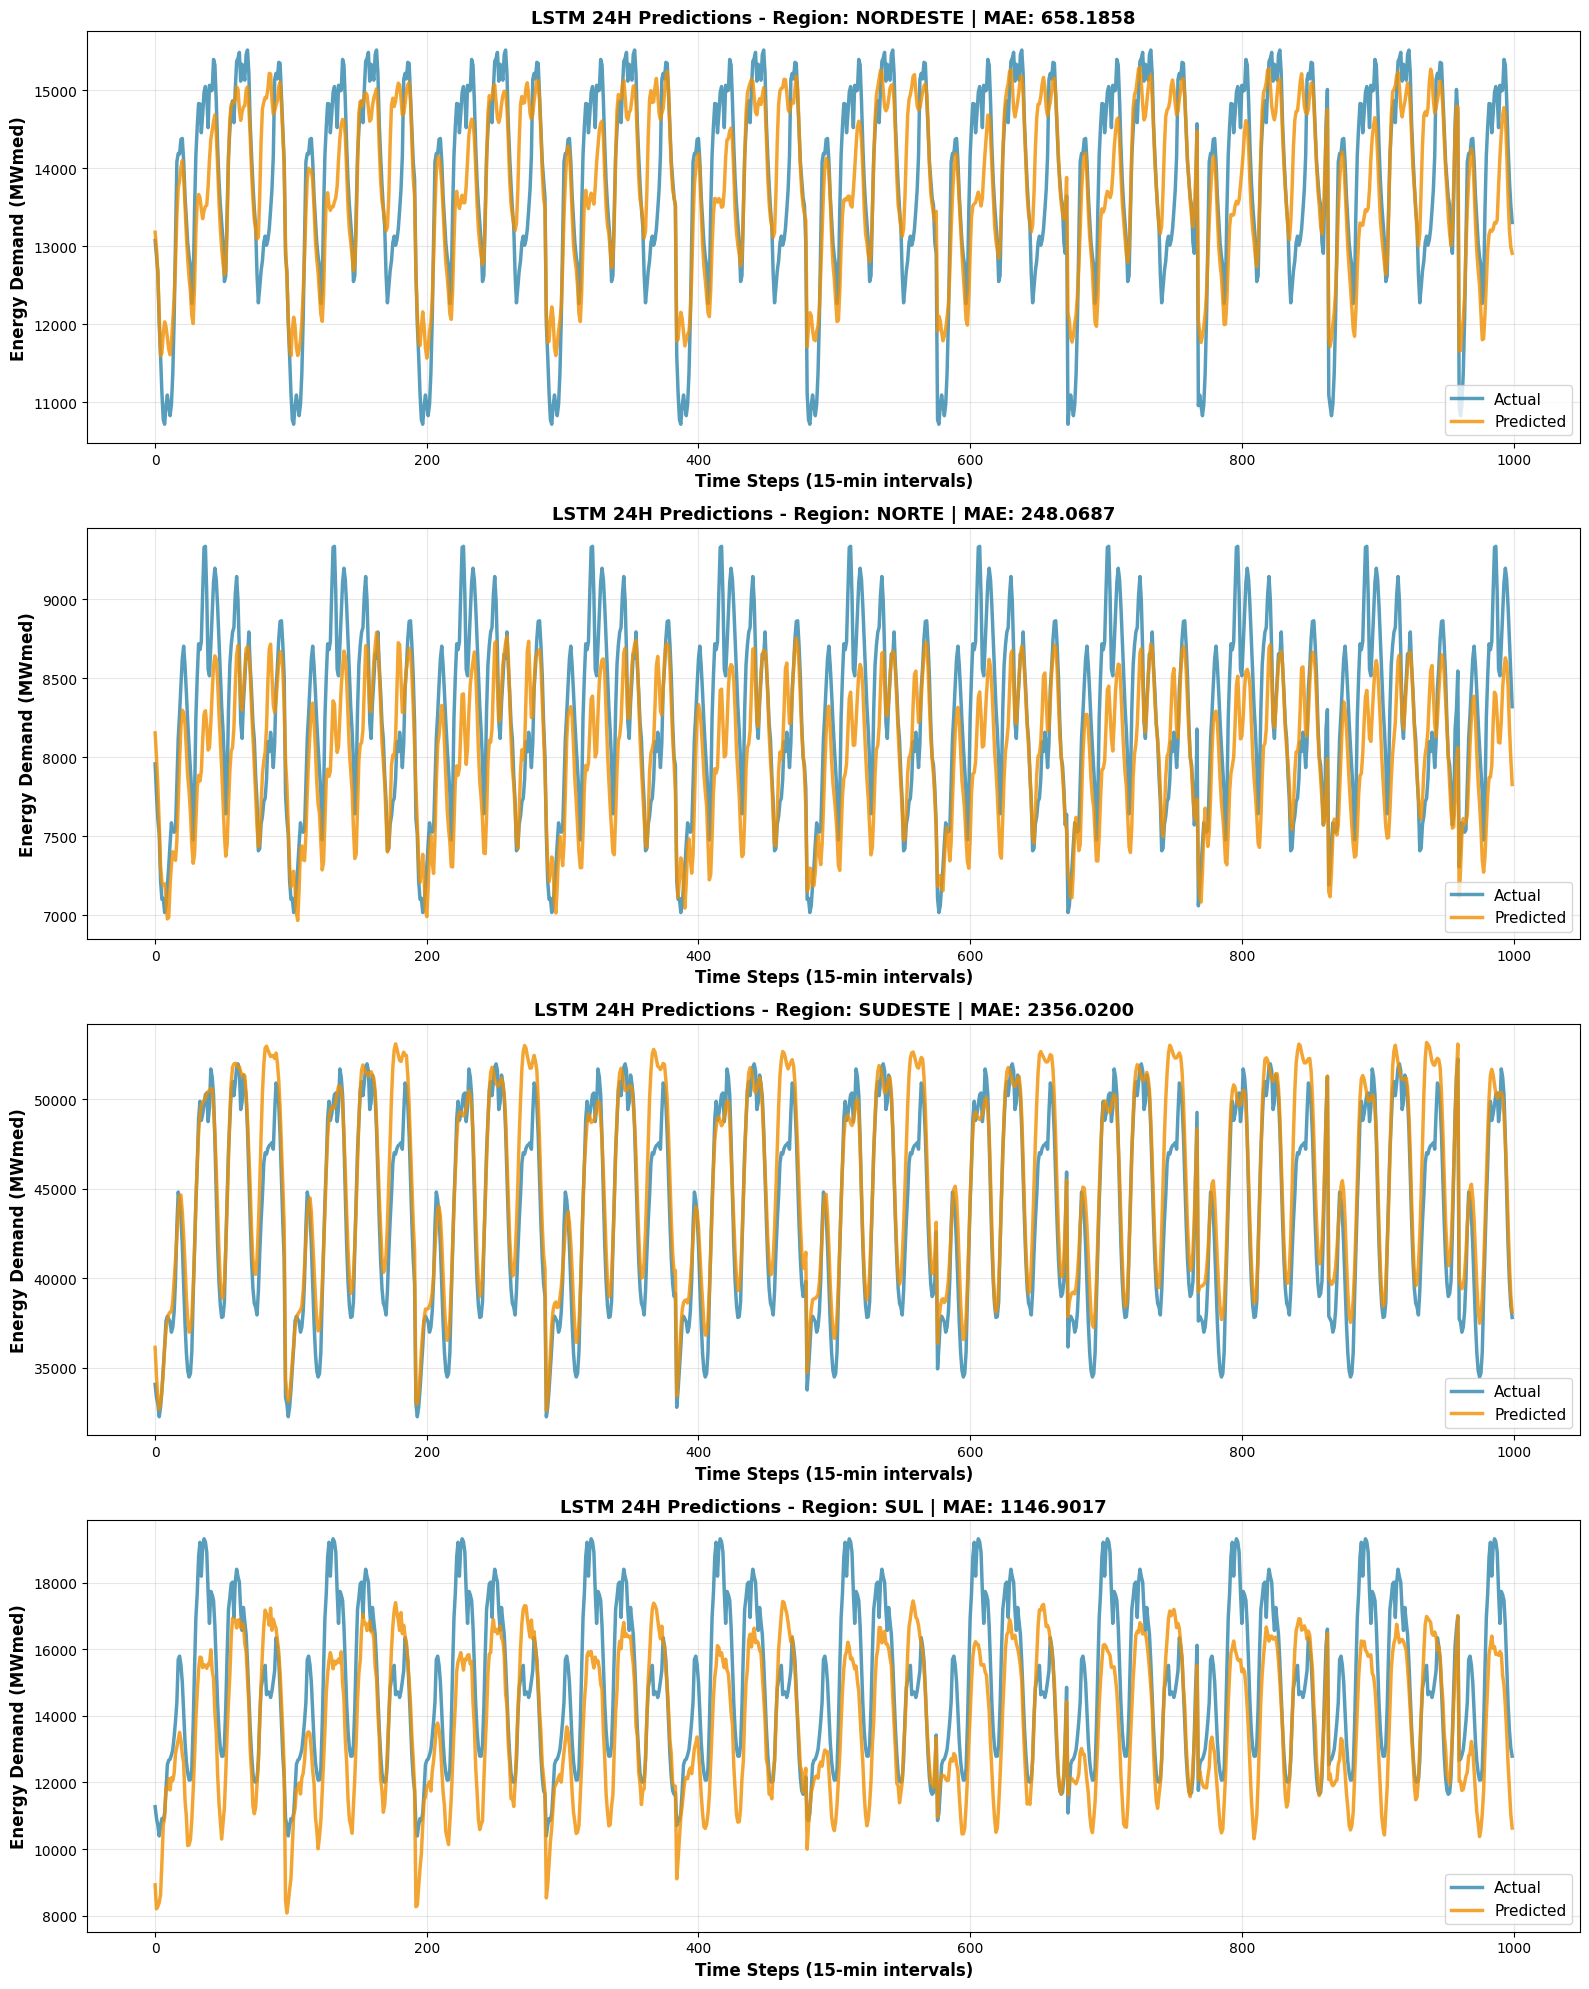

✓ Figure 2 (168H) saved: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\lstm_168h_predictions_all_regions.png



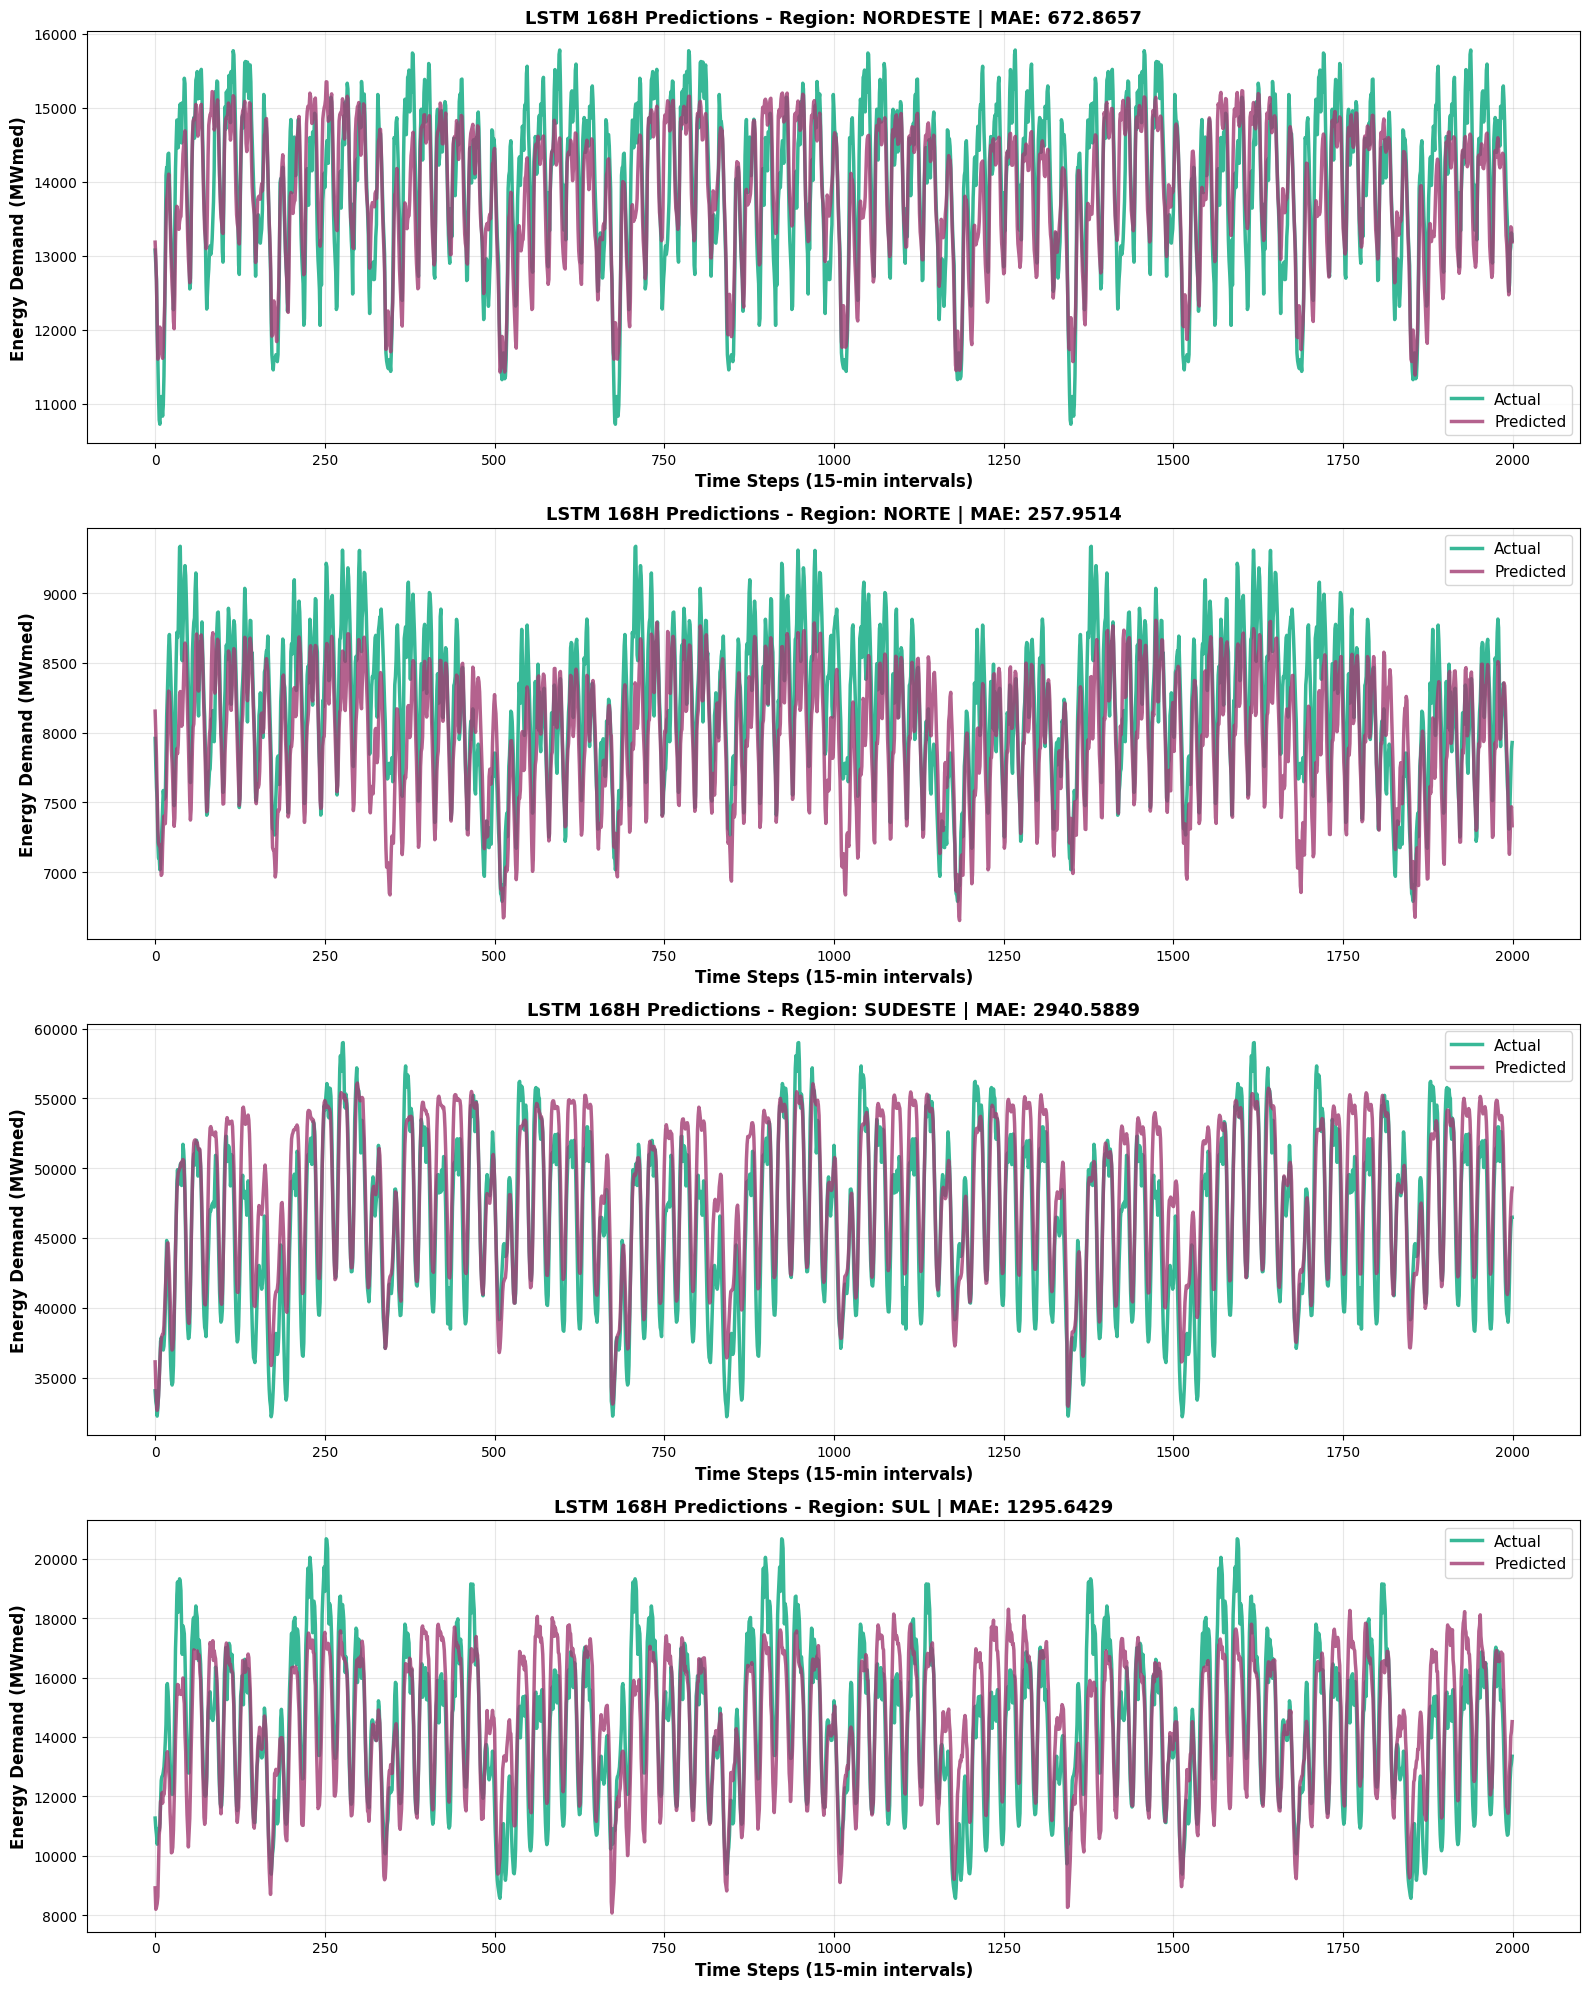

✓ Figure 3 (Side-by-side) saved: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\lstm_24h_168h_side_by_side.png



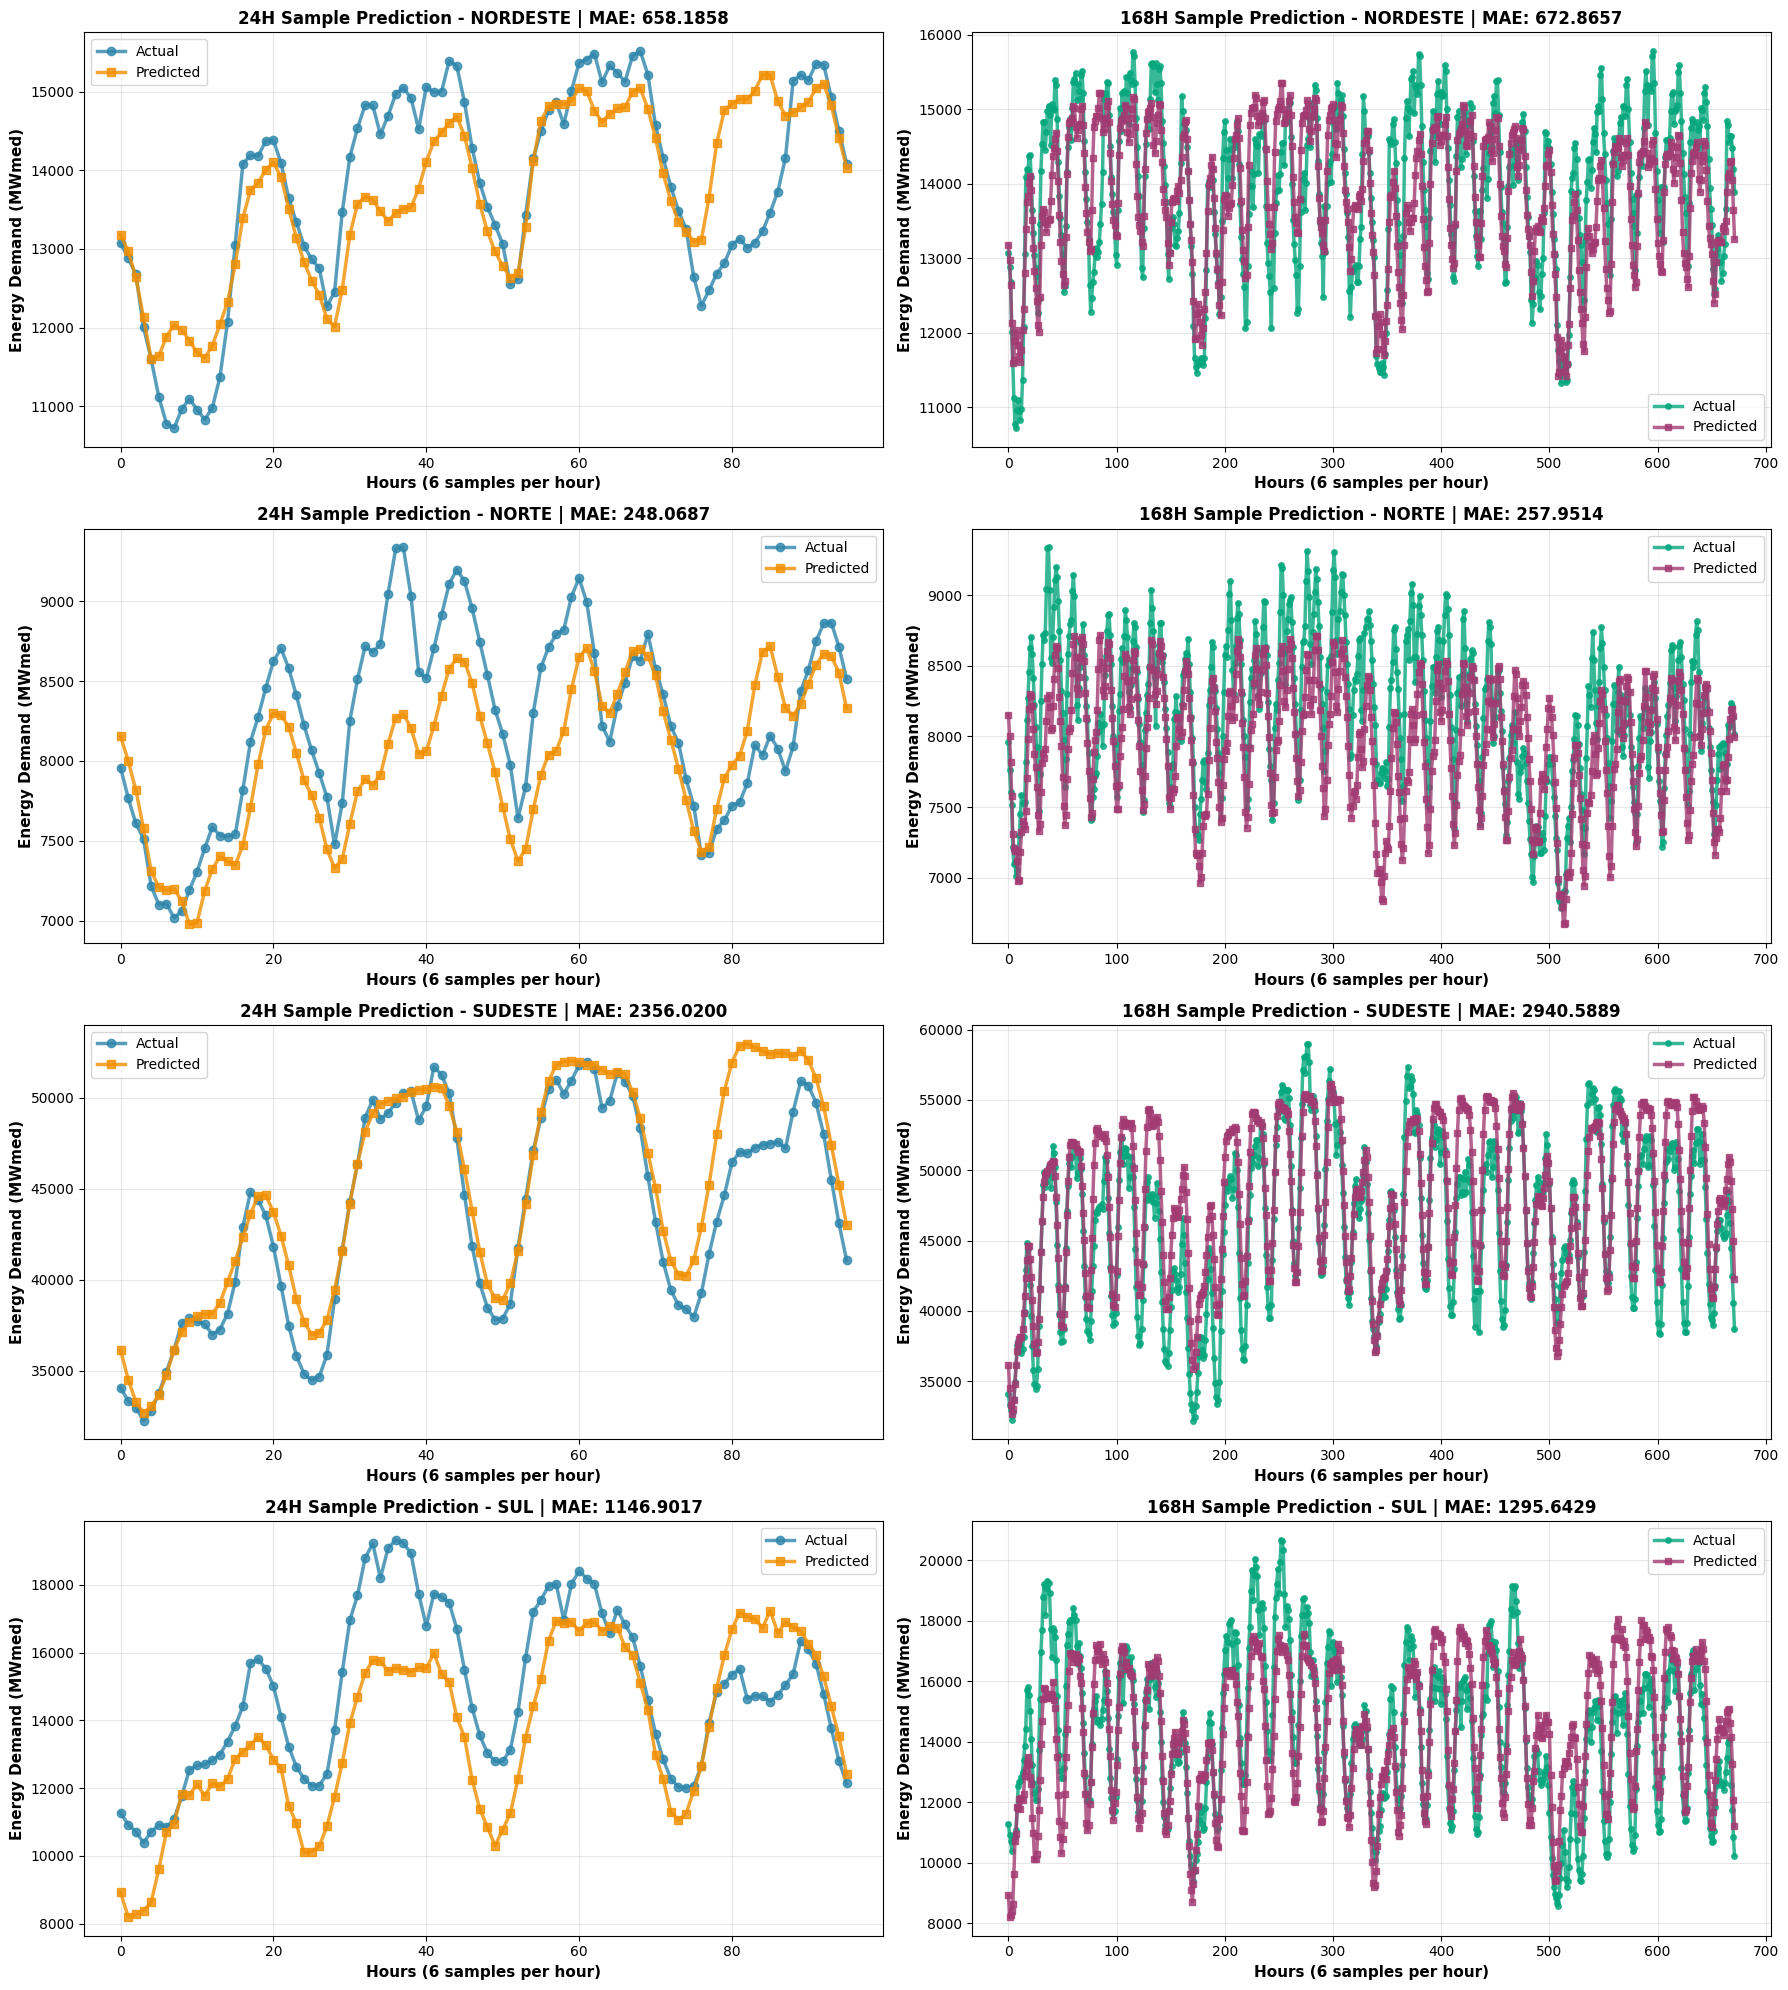

PLOTTING COMPLETE



In [21]:

print(f"\n{'='*80}")
print("PLOTTING 24H AND 168H PREDICTIONS FOR ALL REGIONS")
print(f"{'='*80}\n")

regions_list = list(all_results.keys())
n_regions = len(regions_list)

# ===== FIGURE 1: 24H PREDICTIONS =====
fig, axes = plt.subplots(n_regions, 1, figsize=(16, 5*n_regions))
if n_regions == 1:
    axes = [axes]

for idx, region in enumerate(regions_list):
    ax = axes[idx]
    
    if region in all_results:
        y_pred_24h = all_results[region]["y_preds_test_24h"]  # Shape: (n_samples, 96)
        y_true_24h = all_results[region]["y_truth_test_24h"]  # Shape: (n_samples, 96)
        mae_24h = all_results[region]["mae_24h"]
        
        # Plot first 1000 timesteps for visibility
        n_steps = min(1000, y_pred_24h.shape[0] * y_pred_24h.shape[1])
        y_pred_flat = y_pred_24h.flatten()[:n_steps]
        y_true_flat = y_true_24h.flatten()[:n_steps]  # Fixed: was using y_pred_24h twice
        
        ax.plot(y_true_flat, label='Actual', linewidth=2.5, alpha=0.8, color='#2E86AB')
        ax.plot(y_pred_flat, label='Predicted', linewidth=2.5, alpha=0.8, color='#F18F01')
        
        ax.set_xlabel('Time Steps (15-min intervals)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Energy Demand (MWmed)', fontsize=12, fontweight='bold')
        ax.set_title(f'LSTM 24H Predictions - Region: {region} | MAE: {mae_24h:.4f}',
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
fig1_path = os.path.join(SAVE_DIR, "lstm_24h_predictions_all_regions.png")
plt.savefig(fig1_path, dpi=150, bbox_inches='tight')
print(f"✓ Figure 1 (24H) saved: {fig1_path}\n")
plt.show()

# ===== FIGURE 2: 168H PREDICTIONS =====
fig, axes = plt.subplots(n_regions, 1, figsize=(16, 5*n_regions))
if n_regions == 1:
    axes = [axes]

for idx, region in enumerate(regions_list):
    ax = axes[idx]
    
    if region in all_results:
        y_pred_168h = all_results[region]["y_preds_test_168h"]  # Shape: (n_samples, 672)
        y_true_168h = all_results[region]["y_truth_test_168h"]  # Shape: (n_samples, 672)
        mae_168h = all_results[region]["mae_168h"]
        
        # Plot first 2000 timesteps for visibility
        n_steps = min(2000, y_pred_168h.shape[0] * y_pred_168h.shape[1])
        y_pred_flat = y_pred_168h.flatten()[:n_steps]
        y_true_flat = y_true_168h.flatten()[:n_steps]
        
        ax.plot(y_true_flat, label='Actual', linewidth=2.5, alpha=0.8, color='#06A77D')
        ax.plot(y_pred_flat, label='Predicted', linewidth=2.5, alpha=0.8, color='#A23B72')
        
        ax.set_xlabel('Time Steps (15-min intervals)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Energy Demand (MWmed)', fontsize=12, fontweight='bold')
        ax.set_title(f'LSTM 168H Predictions - Region: {region} | MAE: {mae_168h:.4f}',
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
fig2_path = os.path.join(SAVE_DIR, "lstm_168h_predictions_all_regions.png")
plt.savefig(fig2_path, dpi=150, bbox_inches='tight')
print(f"✓ Figure 2 (168H) saved: {fig2_path}\n")
plt.show()

# ===== FIGURE 3: SIDE-BY-SIDE COMPARISON FOR FIRST SAMPLE =====
fig, axes = plt.subplots(n_regions, 2, figsize=(18, 5*n_regions))
if n_regions == 1:
    axes = [axes]

for idx, region in enumerate(regions_list):
    if region in all_results:
        # 24H subplot
        ax_24h = axes[idx, 0]
        y_pred_24h = all_results[region]["y_preds_test_24h"]
        y_true_24h = all_results[region]["y_truth_test_24h"]
        mae_24h = all_results[region]["mae_24h"]
        
        # Plot first sample only for cleaner visualization
        ax_24h.plot(y_true_24h[0], marker='o', label='Actual', linewidth=2.5, 
                   markersize=6, alpha=0.8, color='#2E86AB')
        ax_24h.plot(y_pred_24h[0], marker='s', label='Predicted', linewidth=2.5, 
                   markersize=6, alpha=0.8, color='#F18F01')
        
        ax_24h.set_xlabel('Hours (6 samples per hour)', fontsize=11, fontweight='bold')
        ax_24h.set_ylabel('Energy Demand (MWmed)', fontsize=11, fontweight='bold')
        ax_24h.set_title(f'24H Sample Prediction - {region} | MAE: {mae_24h:.4f}',
                        fontsize=12, fontweight='bold')
        ax_24h.legend(fontsize=10)
        ax_24h.grid(True, alpha=0.3)
        
        # 168H subplot
        ax_168h = axes[idx, 1]
        y_pred_168h = all_results[region]["y_preds_test_168h"]
        y_true_168h = all_results[region]["y_truth_test_168h"]
        mae_168h = all_results[region]["mae_168h"]
        
        ax_168h.plot(y_true_168h[0], marker='o', label='Actual', linewidth=2.5, 
                    markersize=4, alpha=0.8, color='#06A77D')
        ax_168h.plot(y_pred_168h[0], marker='s', label='Predicted', linewidth=2.5, 
                    markersize=4, alpha=0.8, color='#A23B72')
        
        ax_168h.set_xlabel('Hours (6 samples per hour)', fontsize=11, fontweight='bold')
        ax_168h.set_ylabel('Energy Demand (MWmed)', fontsize=11, fontweight='bold')
        ax_168h.set_title(f'168H Sample Prediction - {region} | MAE: {mae_168h:.4f}',
                         fontsize=12, fontweight='bold')
        ax_168h.legend(fontsize=10)
        ax_168h.grid(True, alpha=0.3)

plt.tight_layout()
fig3_path = os.path.join(SAVE_DIR, "lstm_24h_168h_side_by_side.png")
plt.savefig(fig3_path, dpi=150, bbox_inches='tight')
print(f"✓ Figure 3 (Side-by-side) saved: {fig3_path}\n")
plt.show()

print(f"{'='*80}")
print("PLOTTING COMPLETE")
print(f"{'='*80}\n")

## try to train for hourly data insted of 4 samples/hour

sample data

In [8]:

df['din_instante'] = pd.to_datetime(df['din_instante'])

df_hourly = (df
    .set_index('din_instante')
    .groupby('nom_subsistema')
    .resample('H')
    .agg({
        'val_cargaenergiahomwmed': 'mean',
        'id_subsistema': 'first'
    })
    .reset_index()
)

print(df_hourly.head(20))
print(f"Shape: {df_hourly.shape}")
print(f"Regions preserved: {df_hourly['nom_subsistema'].unique()}")

   nom_subsistema        din_instante  val_cargaenergiahomwmed id_subsistema
0        NORDESTE 2020-01-01 00:00:00                 9617.975            NE
1        NORDESTE 2020-01-01 01:00:00                 9628.517            NE
2        NORDESTE 2020-01-01 02:00:00                 9652.756            NE
3        NORDESTE 2020-01-01 03:00:00                 9600.859            NE
4        NORDESTE 2020-01-01 04:00:00                 9496.766            NE
5        NORDESTE 2020-01-01 05:00:00                 8875.656            NE
6        NORDESTE 2020-01-01 06:00:00                 8331.656            NE
7        NORDESTE 2020-01-01 07:00:00                 8280.969            NE
8        NORDESTE 2020-01-01 08:00:00                 8227.924            NE
9        NORDESTE 2020-01-01 09:00:00                 8203.378            NE
10       NORDESTE 2020-01-01 10:00:00                 8203.915            NE
11       NORDESTE 2020-01-01 11:00:00                 8351.319            NE

In [9]:
df_hourly_cleaned_list  = []
sub_sys_names = df_hourly['nom_subsistema'].unique()

for subsistema_name in sub_sys_names:
    df_subsystem = df_hourly[df_hourly['nom_subsistema'] == subsistema_name].copy()
    df_subsystem['din_instante'] = pd.to_datetime(df_subsystem['din_instante'])
    df_subsystem = df_subsystem.set_index('din_instante').sort_index()

    # Apply the outlier detection and fixing pipeline, passing the holiday dates
    cleaned_series, audit_df ,details_df= brazil_outlier_pipeline(df_subsystem['val_cargaenergiahomwmed'], holiday_dates=holiday_dates_list,z_thresh=2.0,rolling_window=24)

    # Create a new DataFrame for the cleaned data of this subsystem
    df_subsystem_cleaned = df_subsystem.copy()
    df_subsystem_cleaned['val_cargaenergiahomwmed_cleaned'] = cleaned_series

    df_hourly_cleaned_list .append(df_subsystem_cleaned.reset_index())

df_hourly_cleaned = pd.concat(df_hourly_cleaned_list , ignore_index=True)

print("Original vs. Cleaned data sample:")
print(df_hourly_cleaned[['din_instante', 'nom_subsistema', 'val_cargaenergiahomwmed', 'val_cargaenergiahomwmed_cleaned']].head())

Original vs. Cleaned data sample:
         din_instante nom_subsistema  val_cargaenergiahomwmed  \
0 2020-01-01 00:00:00       NORDESTE                 9617.975   
1 2020-01-01 01:00:00       NORDESTE                 9628.517   
2 2020-01-01 02:00:00       NORDESTE                 9652.756   
3 2020-01-01 03:00:00       NORDESTE                 9600.859   
4 2020-01-01 04:00:00       NORDESTE                 9496.766   

   val_cargaenergiahomwmed_cleaned  
0                         9617.975  
1                         9628.517  
2                         9652.756  
3                         9600.859  
4                         9496.766  


In [10]:
all_features_hourly_df = []

for subsistema_name in df_hourly_cleaned['nom_subsistema'].unique():
    df_subsystem_cleaned = df_hourly_cleaned[df_hourly_cleaned['nom_subsistema'] == subsistema_name].copy()

    # Convert 'din_instante' to datetime and set as index for the function
    df_subsystem_cleaned['din_instante'] = pd.to_datetime(df_subsystem_cleaned['din_instante'])
    df_subsystem_cleaned = df_subsystem_cleaned.set_index('din_instante')

    # Ensure the 'nom_subsistema' is an object type for TimeSeriesDataSet
    df_subsystem_cleaned['nom_subsistema'] = df_subsystem_cleaned['nom_subsistema'].astype(str)

    # Build features for the current region
    features_df_region = build_features_for_region(
        df_subsystem_cleaned,
        target_col='val_cargaenergiahomwmed_cleaned',freq='H'
    )

    # Add the subsystem name back as a column for identification after concatenation
    features_df_region['nom_subsistema'] = subsistema_name
    all_features_hourly_df.append(features_df_region)

df_hourly_features = pd.concat(all_features_hourly_df, ignore_index=True)

print("Features DataFrame head:")
display(df_hourly_features.head())

Features DataFrame head:


ds nom_subsistema  val_cargaenergiahomwmed id_subsistema  \
0 2020-01-08 00:00:00       NORDESTE                11506.541            NE   
1 2020-01-08 01:00:00       NORDESTE                11150.702            NE   
2 2020-01-08 02:00:00       NORDESTE                10956.622            NE   
3 2020-01-08 03:00:00       NORDESTE                10763.959            NE   
4 2020-01-08 04:00:00       NORDESTE                10571.510            NE   

      target  time_idx  hour  dow  month  is_weekend  minute  minute_sin  \
0  11506.541       168     0    2      1           0       0         0.0   
1  11150.702       169     1    2      1           0       0         0.0   
2  10956.622       170     2    2      1           0       0         0.0   
3  10763.959       171     3    2      1           0       0         0.0   
4  10571.510       172     4    2      1           0       0         0.0   

   minute_cos  hour_sin  hour_cos   dow_sin   dow_cos     lag_1h    lag_24h  \
0         1.0  0.000000  1.000000  0.974928 -0.222521  11894.481  11235.741   
1         1.0  0.258819  0.965926  0.974928 -0.222521  11506.541  10981.286   
2         1.0  0.500000  0.866025  0.974928 -0.222521  11150.702  10778.995   
3         1.0  0.707107  0.707107  0.974928 -0.222521  10956.622  10610.971   
4         1.0  0.866025  0.500000  0.974928 -0.222521  10763.959  10509.448   

   lag_168h  
0  9617.975  
1  9628.517  
2  9652.756  
3  9600.859  
4  9496.766

In [18]:
# ============ HOURLY DATA HYPERPARAMETERS ============
# New hyperparameters for hourly resolution (flagged with [HOURLY])
FREQ_HOURLY = 'H'                    # [HOURLY] Hourly frequency
ENCODER_HOURS_HOURLY = 168           # [HOURLY] 1 week lookback
ENCODER_LEN_HOURLY = ENCODER_HOURS_HOURLY * 1  # [HOURLY] 1 sample/hour = 168 steps
PRED_HOURS_HOURLY = 168              # [HOURLY] Predict 1 week ahead
PRED_LEN_HOURLY = PRED_HOURS_HOURLY * 1  # [HOURLY] 168 steps
EVAL_SHORT_HOURS_HOURLY = 24         # [HOURLY] 24h evaluation window
EVAL_SHORT_H_HOURLY = EVAL_SHORT_HOURS_HOURLY * 1  # [HOURLY] 24 steps

BATCH_SIZE_HOURLY = 32               # [HOURLY] Larger batch for hourly data
LR_HOURLY = 5e-4                     # [HOURLY] Slightly lower learning rate
MAX_EPOCHS_HOURLY = 40               # [HOURLY] More epochs for hourly training
NUM_WORKERS_HOURLY = 0
TARGET_COL_HOURLY = "target_hourly"  # [HOURLY] New target column name
REGION_COL = "nom_subsistema"        # Keep same
TIME_COL_HOURLY = "ds_hourly"        # [HOURLY] New datetime column

VAL_DAYS_HOURLY = 14                 # [HOURLY] 14 days validation
TEST_DAYS_HOURLY = 30                # [HOURLY] 30 days test
SAMPLES_PER_DAY_HOURLY = 24          # [HOURLY] 24 samples per day

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR_HOURLY = os.path.join(DRIVE_PATH, "lstm_hourly_results")
os.makedirs(SAVE_DIR_HOURLY, exist_ok=True)

print(f"\n{'='*80}")
print("HOURLY DATA HYPERPARAMETERS SUMMARY")
print(f"{'='*80}")
print(f"Frequency:           {FREQ_HOURLY}")
print(f"Encoder Length:      {ENCODER_LEN_HOURLY} hours")
print(f"Prediction Length:   {PRED_LEN_HOURLY} hours")
print(f"Batch Size:          {BATCH_SIZE_HOURLY}")
print(f"Learning Rate:       {LR_HOURLY}")
print(f"Max Epochs:          {MAX_EPOCHS_HOURLY}")
print(f"Samples/Day:         {SAMPLES_PER_DAY_HOURLY}")
print(f"{'='*80}\n")


HOURLY DATA HYPERPARAMETERS SUMMARY
Frequency:           H
Encoder Length:      168 hours
Prediction Length:   168 hours
Batch Size:          32
Learning Rate:       0.0005
Max Epochs:          40
Samples/Day:         24



In [ ]:
regions = df_hourly_features[REGION_COL].unique()
models = []
for r in regions:
    df_r = df_hourly_features[df_hourly_features[REGION_COL] == r].copy()
    temp_dataset = RegionDataset(df_r, ENCODER_HOURS_HOURLY, PRED_HOURS_HOURLY, split='train')
    n_features = temp_dataset[0][0].shape[1]
    models.append(LitLSTM(n_features=n_features))


In [58]:
results=train_lstm_per_region(df_hourly_features,models=models,save_dir=SAVE_DIR_HOURLY,encoder_len=ENCODER_HOURS_HOURLY,pred_len=PRED_HOURS_HOURLY,duration_persample=60)


=== TRAINING REGION: NORDESTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 206 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
258 K     Trainable params
0         Non-trainable params
258 K     Total params
1.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NORDESTE] Test MAE 24h: 580.703, 168h: 599.273

=== TRAINING REGION: NORTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 206 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
258 K     Trainable params
0         Non-trainable params
258 K     Total params
1.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NORTE] Test MAE 24h: 226.297, 168h: 229.803

=== TRAINING REGION: SUDESTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 206 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
258 K     Trainable params
0         Non-trainable params
258 K     Total params
1.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[SUDESTE] Test MAE 24h: 2439.827, 168h: 2887.178

=== TRAINING REGION: SUL ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 206 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
258 K     Trainable params
0         Non-trainable params
258 K     Total params
1.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[SUL] Test MAE 24h: 1125.933, 168h: 1282.022


Loss curves saved to: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_hourly_results\all_regions_loss_curves.png


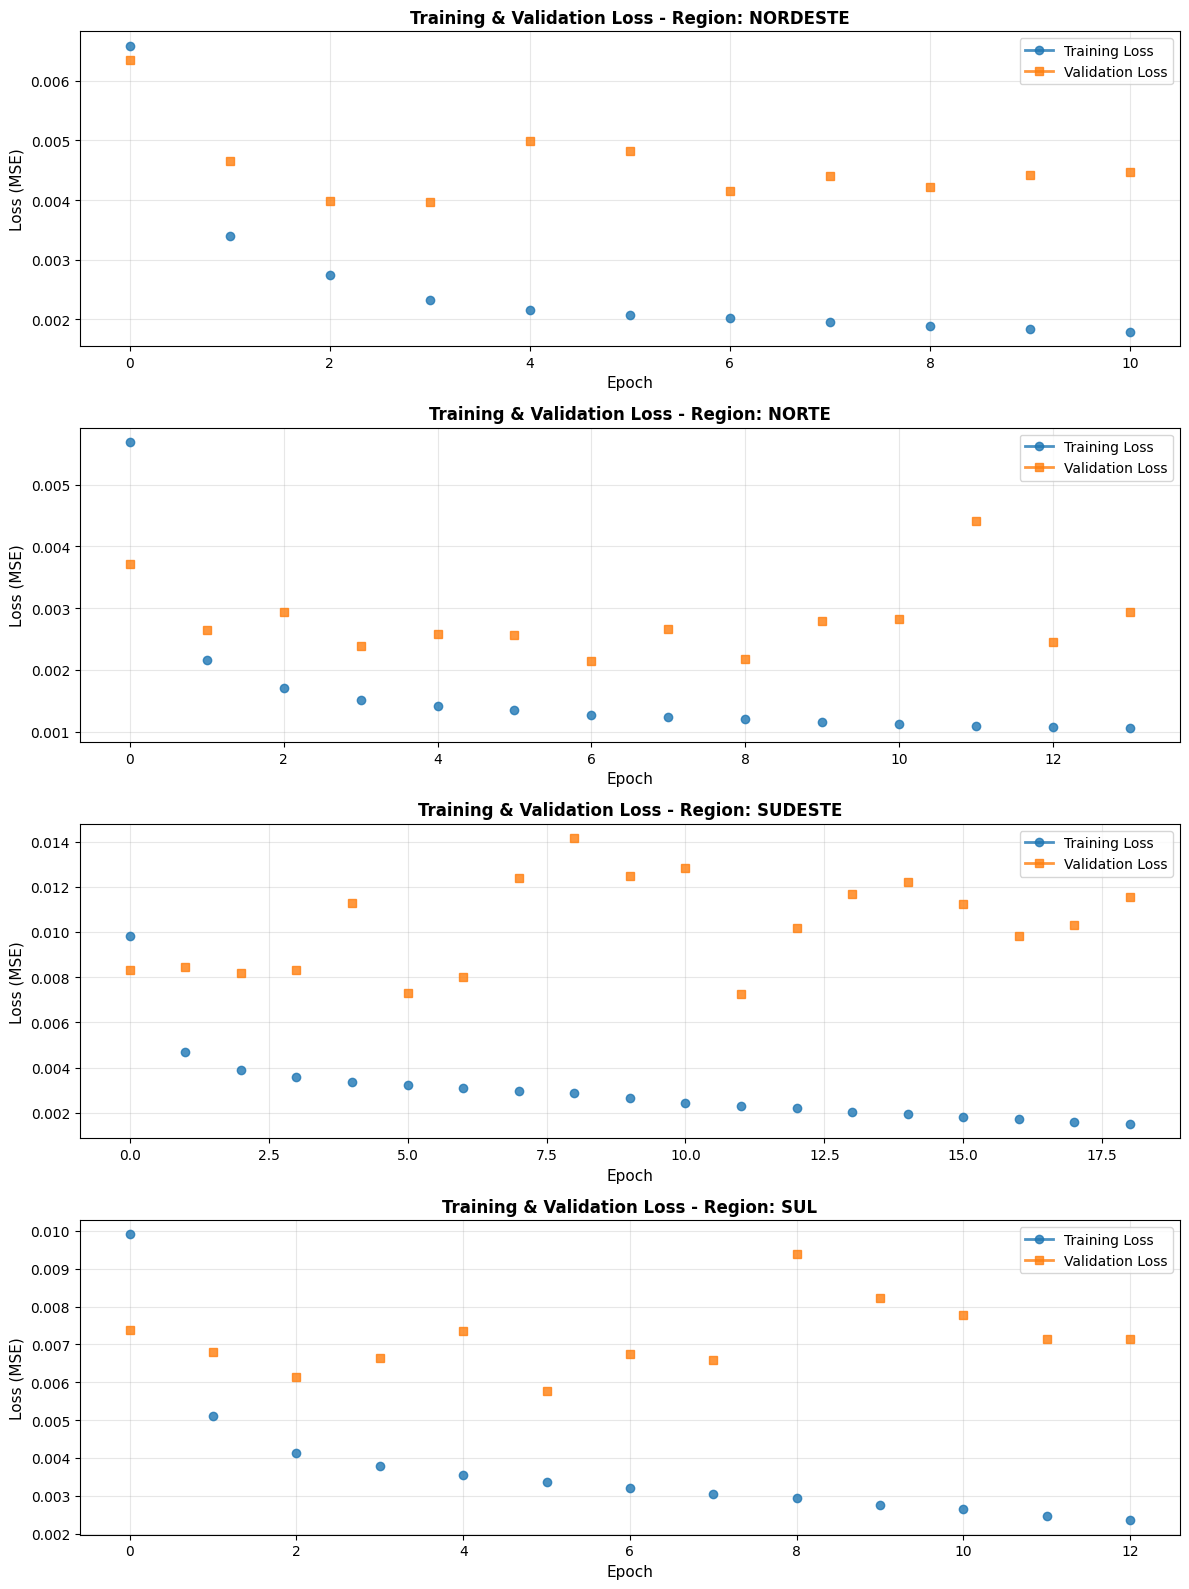

Prediction plots saved to: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_hourly_results\all_regions_predictions.png


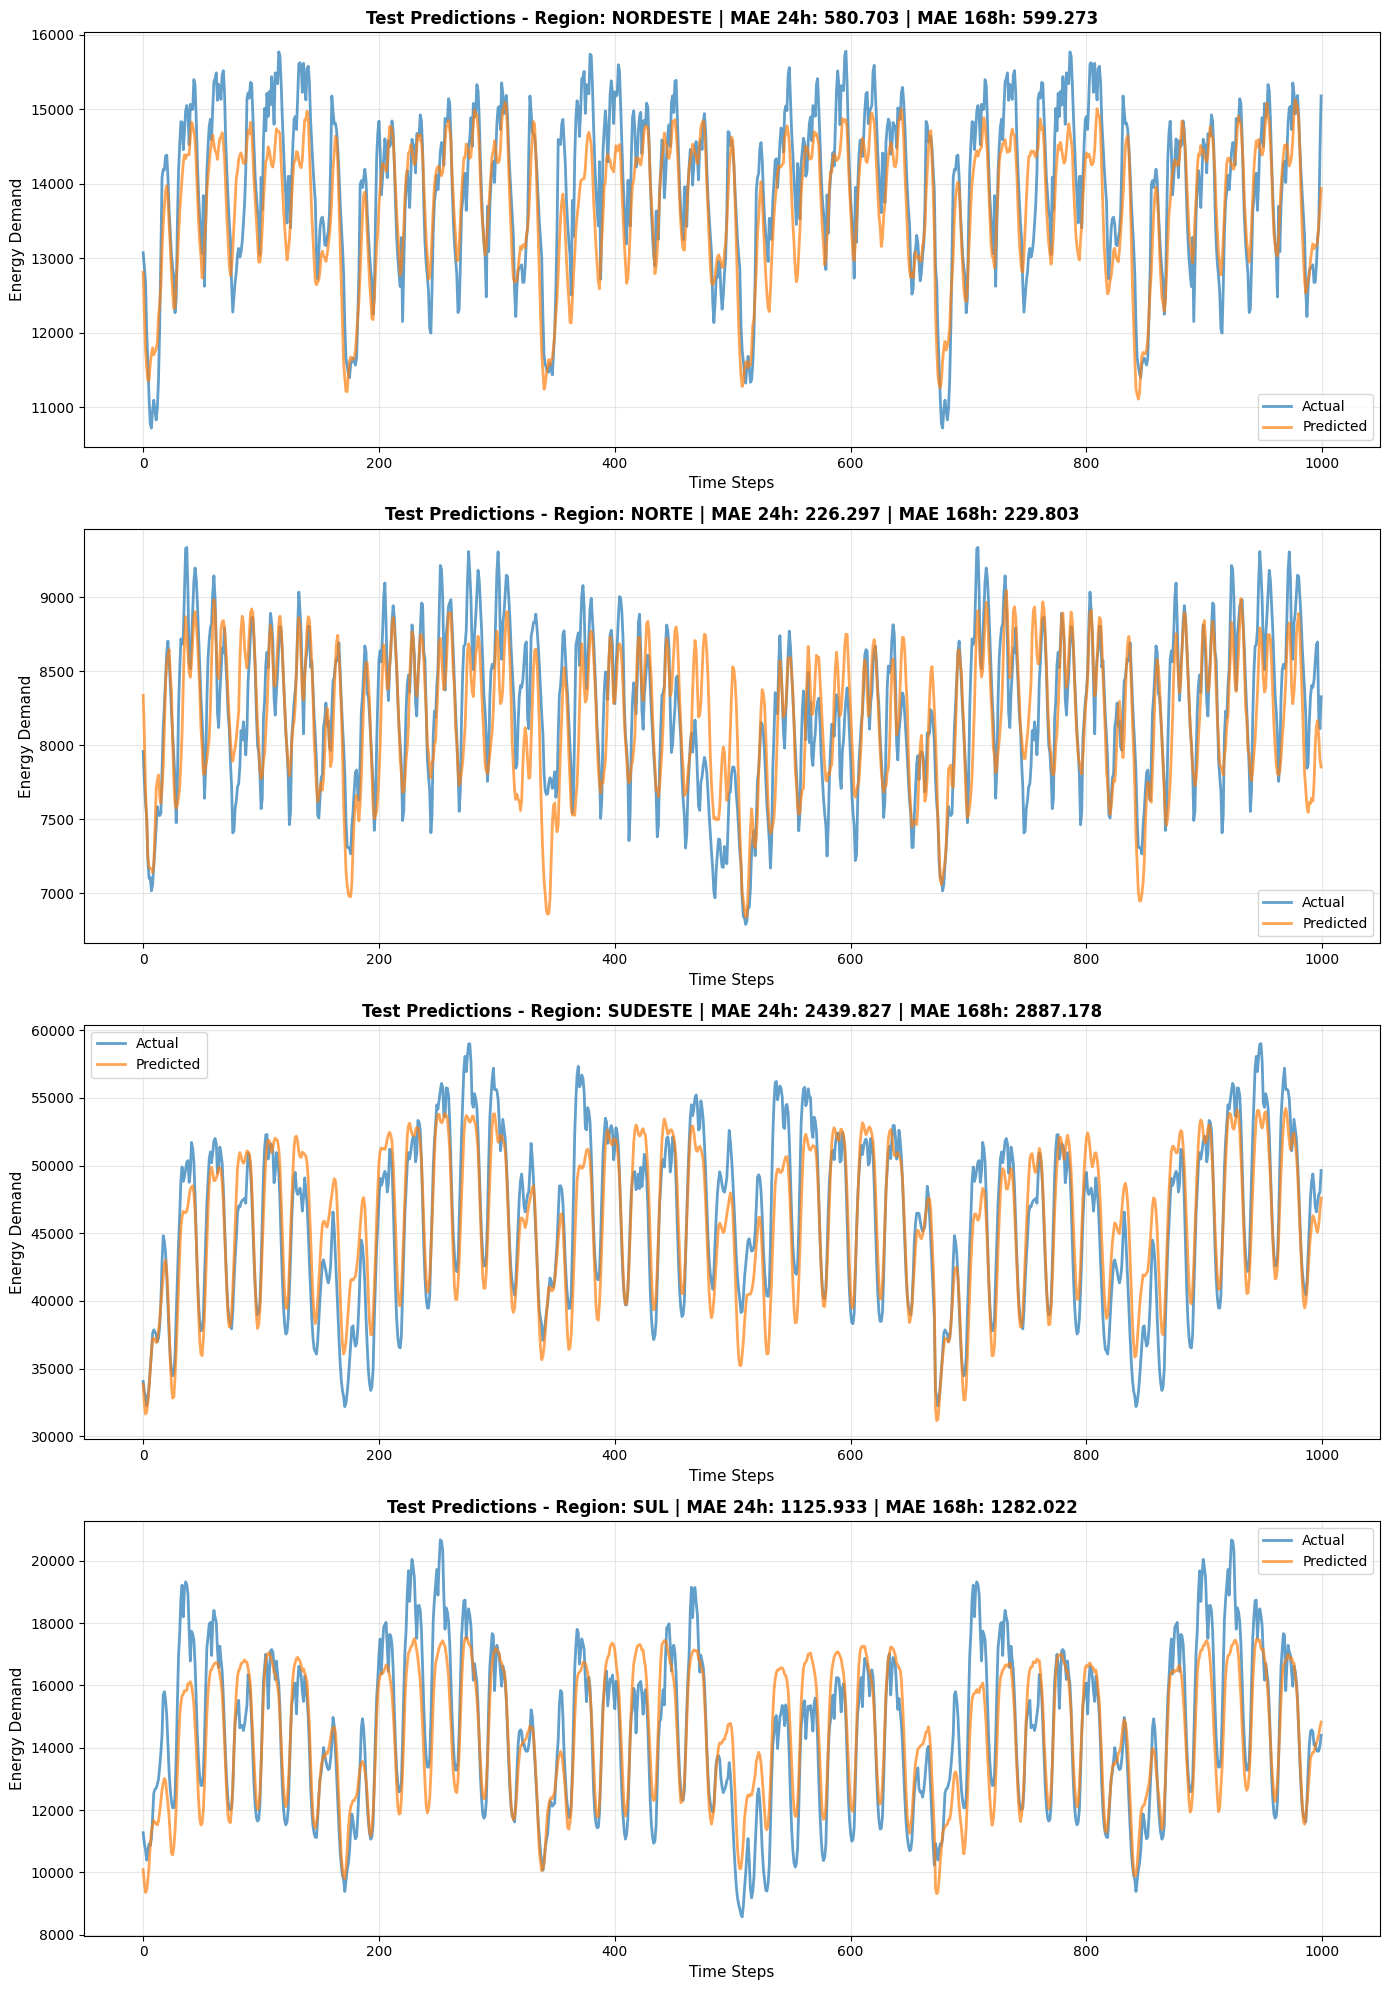

Metrics comparison saved to: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_hourly_results\metrics_comparison.png


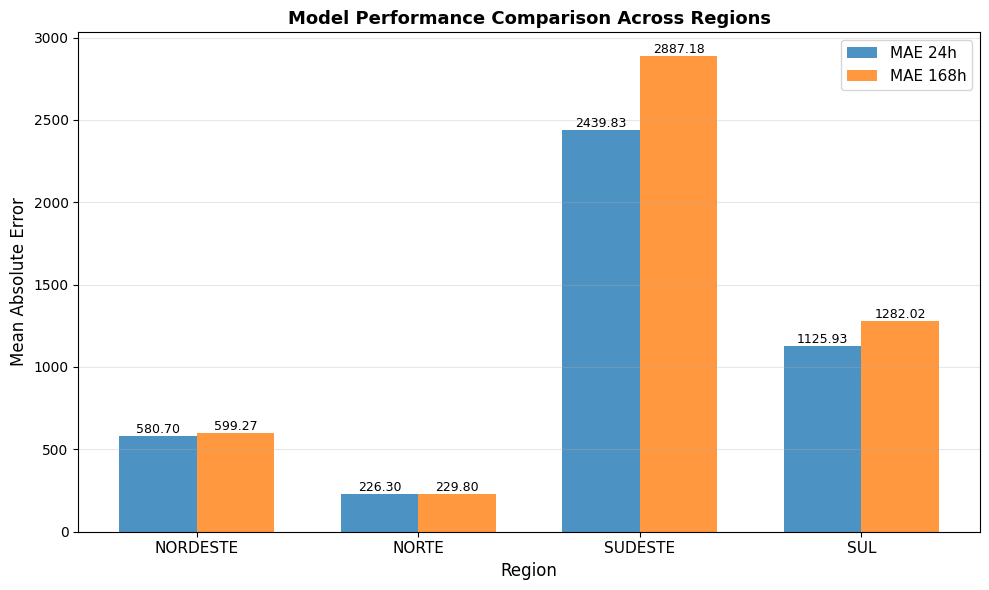

In [59]:
plot_all_results(results,SAVE_DIR_HOURLY)

**increasing dropout rate**

In [65]:
regions=df_hourly_features[REGION_COL].unique()
models_higher_dropout=[]

for r in regions:
    df_r = df_hourly_features[df_hourly_features[REGION_COL] == r].copy()
    temp_dataset = RegionDataset(df_r, ENCODER_HOURS_HOURLY, PRED_HOURS_HOURLY, split='train')
    n_features = temp_dataset[0][0].shape[1]
    models_higher_dropout.append(LitLSTM(n_features=n_features,dropout=0.25))



In [66]:
higher_dropout_results=train_lstm_per_region(df_hourly_features,models=models_higher_dropout,save_dir=SAVE_DIR_HOURLY,encoder_len=ENCODER_HOURS_HOURLY,pred_len=PRED_HOURS_HOURLY,duration_persample=60)


=== TRAINING REGION: NORDESTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 206 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
258 K     Trainable params
0         Non-trainable params
258 K     Total params
1.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


[NORDESTE] Test MAE 24h: 721.926, 168h: 645.535

=== TRAINING REGION: NORTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 206 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
258 K     Trainable params
0         Non-trainable params
258 K     Total params
1.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NORTE] Test MAE 24h: 230.027, 168h: 232.698

=== TRAINING REGION: SUDESTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 206 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
258 K     Trainable params
0         Non-trainable params
258 K     Total params
1.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[SUDESTE] Test MAE 24h: 3088.108, 168h: 3392.715

=== TRAINING REGION: SUL ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 206 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
258 K     Trainable params
0         Non-trainable params
258 K     Total params
1.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[SUL] Test MAE 24h: 1138.231, 168h: 1283.575


Loss curves saved to: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\all_regions_loss_curves.png


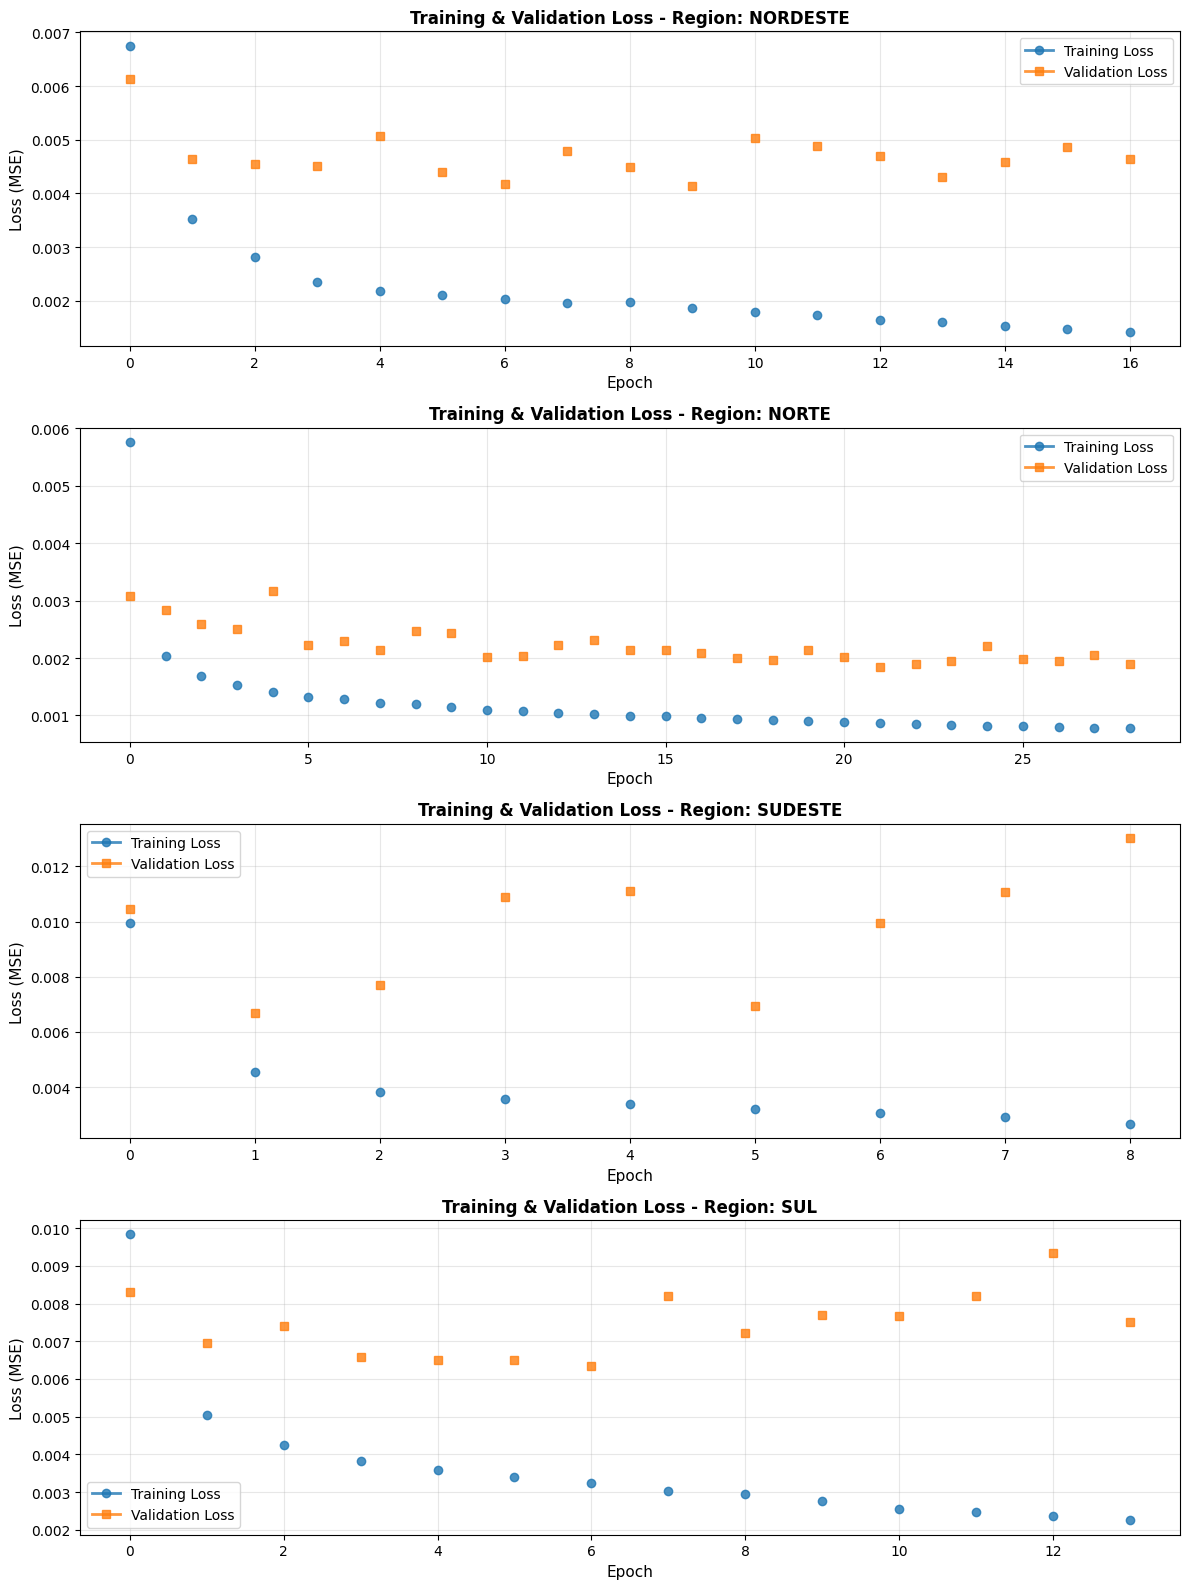

Prediction plots saved to: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\all_regions_predictions.png


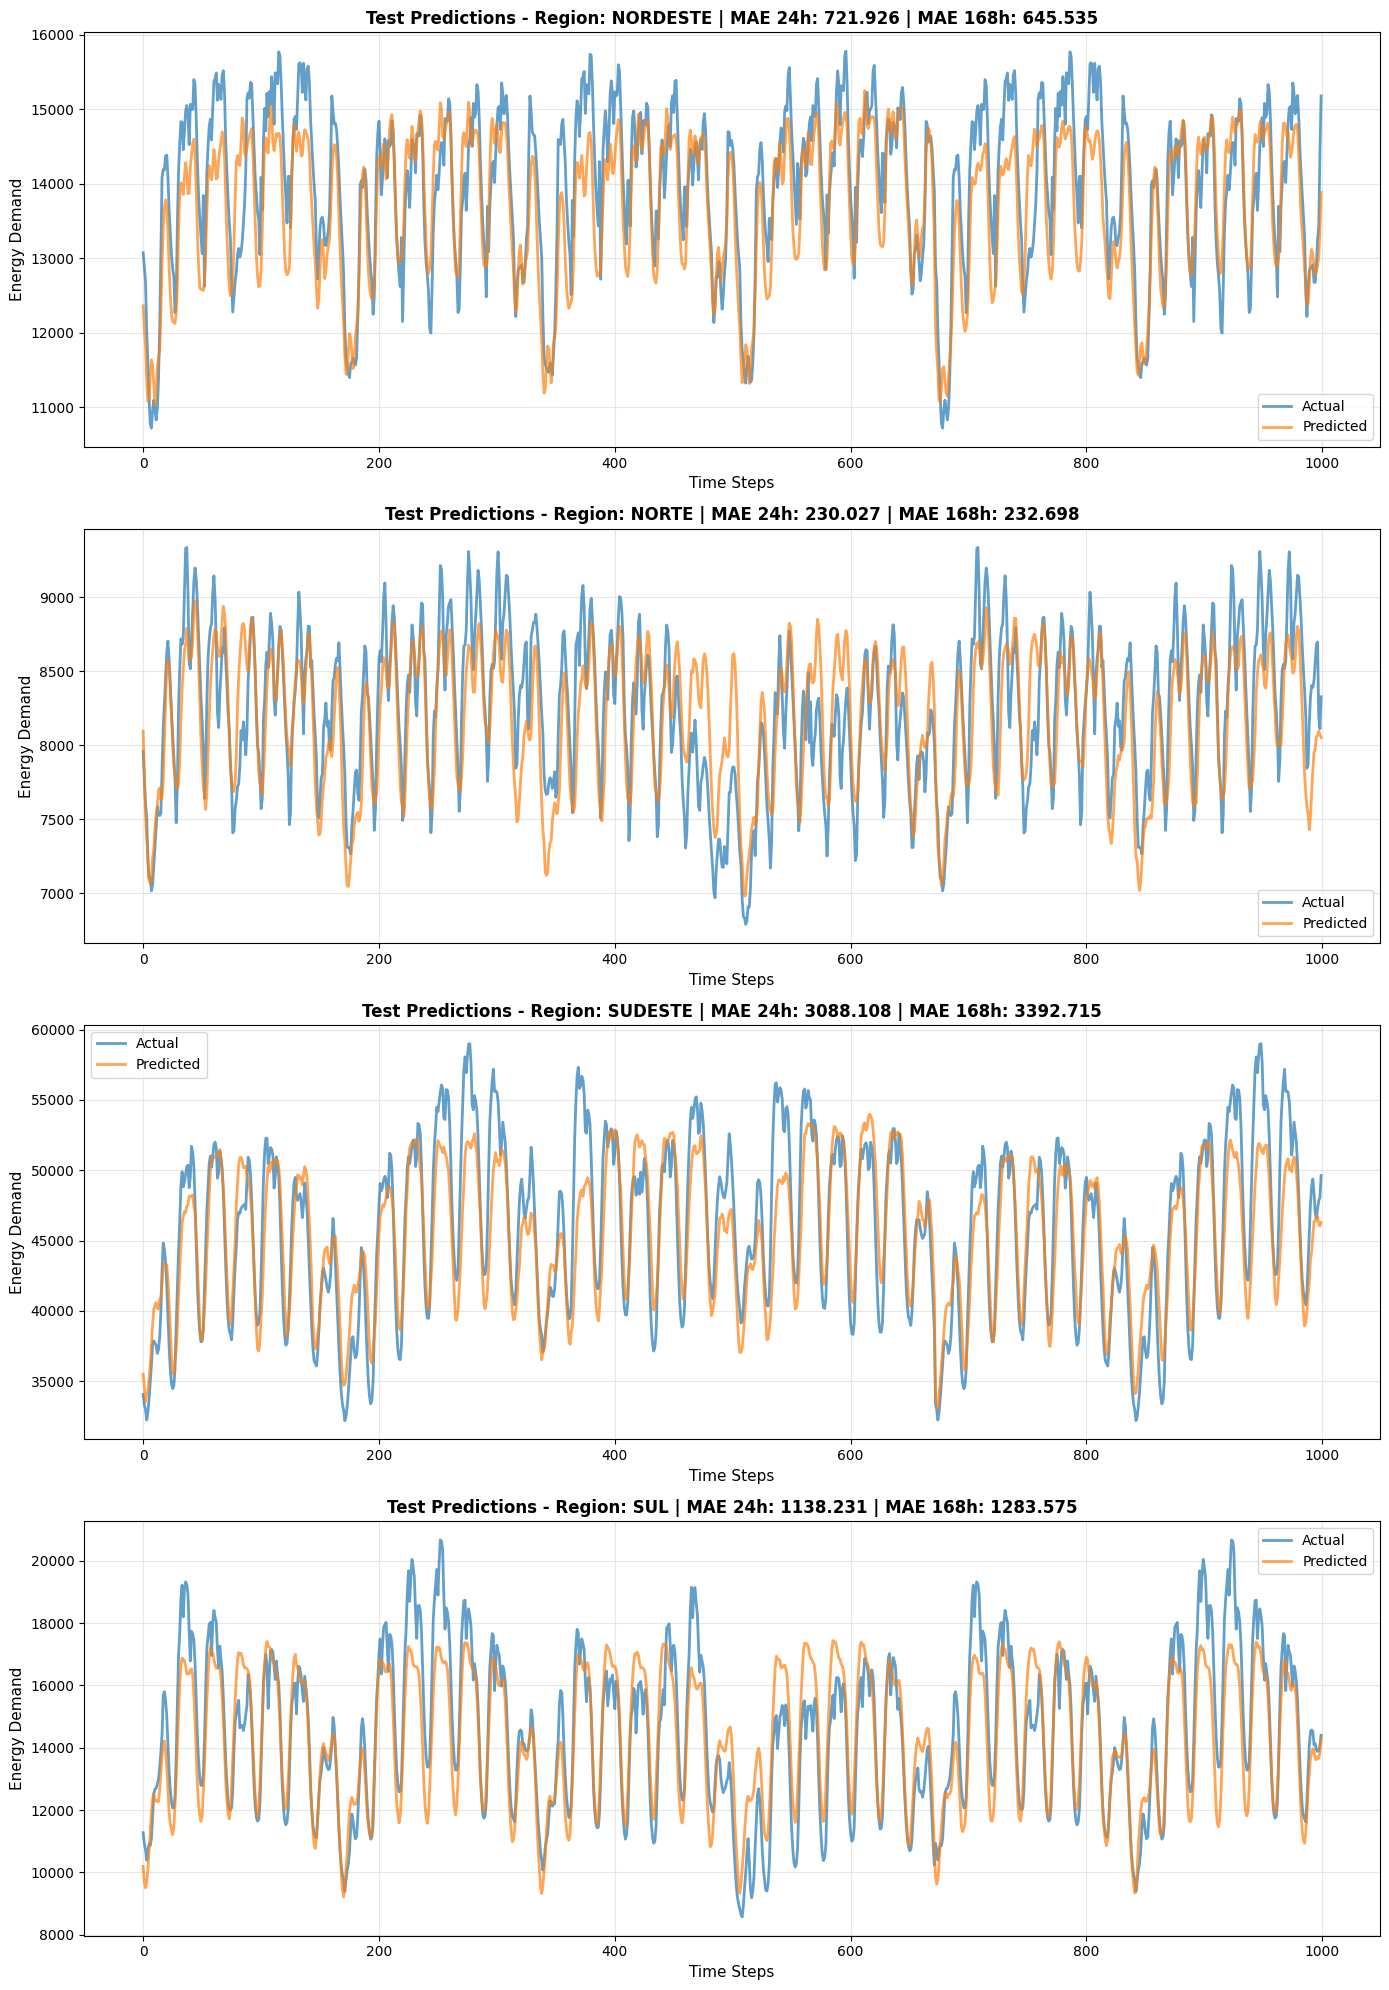

Metrics comparison saved to: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\metrics_comparison.png


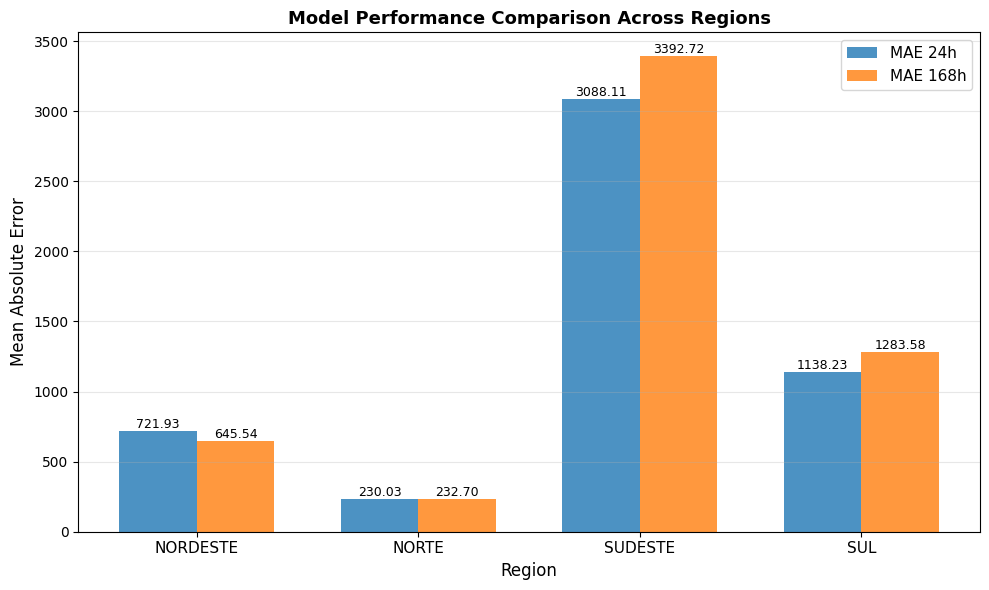

In [67]:
plot_all_results(higher_dropout_results)

## adding more features , rolling mean , rolling std

In [13]:
df_hourly_added_features=df_hourly_features.copy()
# Rolling mean
df_hourly_added_features['rmean_3h']   = df_hourly_added_features['target'].shift(1).rolling(window=3, min_periods=1).mean()
df_hourly_added_features['rmean_24h']  = df_hourly_added_features['target'].shift(1).rolling(window=24, min_periods=1).mean()
df_hourly_added_features['rmean_168h'] = df_hourly_added_features['target'].shift(1).rolling(window=168, min_periods=1).mean()

# Rolling standard deviation
df_hourly_added_features['rstd_3h']   = df_hourly_added_features['target'].shift(1).rolling(window=3, min_periods=1).std()
df_hourly_added_features['rstd_24h']  = df_hourly_added_features['target'].shift(1).rolling(window=24, min_periods=1).std()
df_hourly_added_features['rstd_168h'] = df_hourly_added_features['target'].shift(1).rolling(window=168, min_periods=1).std()


In [77]:
added_feat_models=[]

for r in regions:
    df_r = df_hourly_added_features[df_hourly_added_features[REGION_COL] == r].copy()
    temp_dataset = RegionDataset(df_r, ENCODER_HOURS_HOURLY, PRED_HOURS_HOURLY, split='train')
    n_features = temp_dataset[0][0].shape[1]
    added_feat_models.append(LitLSTM(n_features=n_features))


In [81]:
added_feat_results=train_lstm_per_region(df_hourly_added_features,models=added_feat_models,save_dir=SAVE_DIR_HOURLY,encoder_len=ENCODER_HOURS_HOURLY,pred_len=PRED_HOURS_HOURLY,duration_persample=60,patience=12)


=== TRAINING REGION: NORDESTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 209 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NORDESTE] Test MAE 24h: 541.165, 168h: 596.938

=== TRAINING REGION: NORTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 209 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


[NORTE] Test MAE 24h: 282.711, 168h: 264.558

=== TRAINING REGION: SUDESTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 209 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[SUDESTE] Test MAE 24h: 2341.299, 168h: 3058.366

=== TRAINING REGION: SUL ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 209 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[SUL] Test MAE 24h: 1087.120, 168h: 1313.272


Loss curves saved to: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\all_regions_loss_curves.png


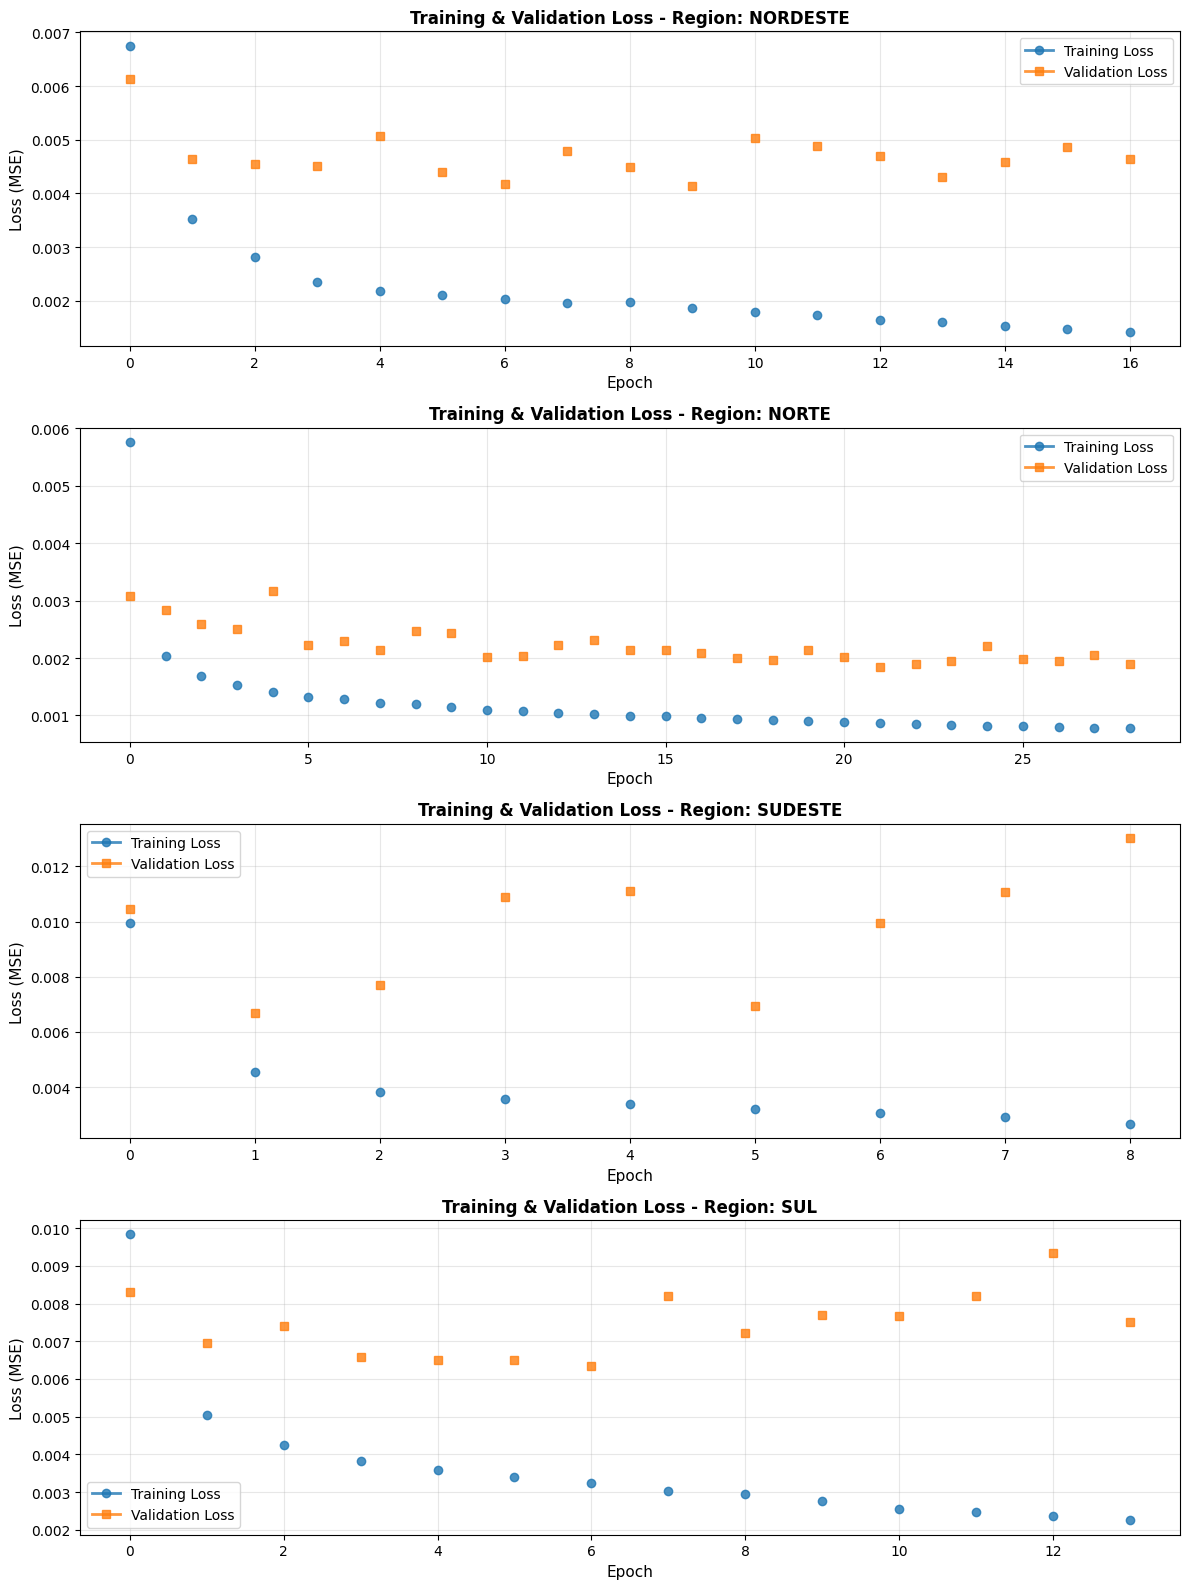

Prediction plots saved to: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\all_regions_predictions.png


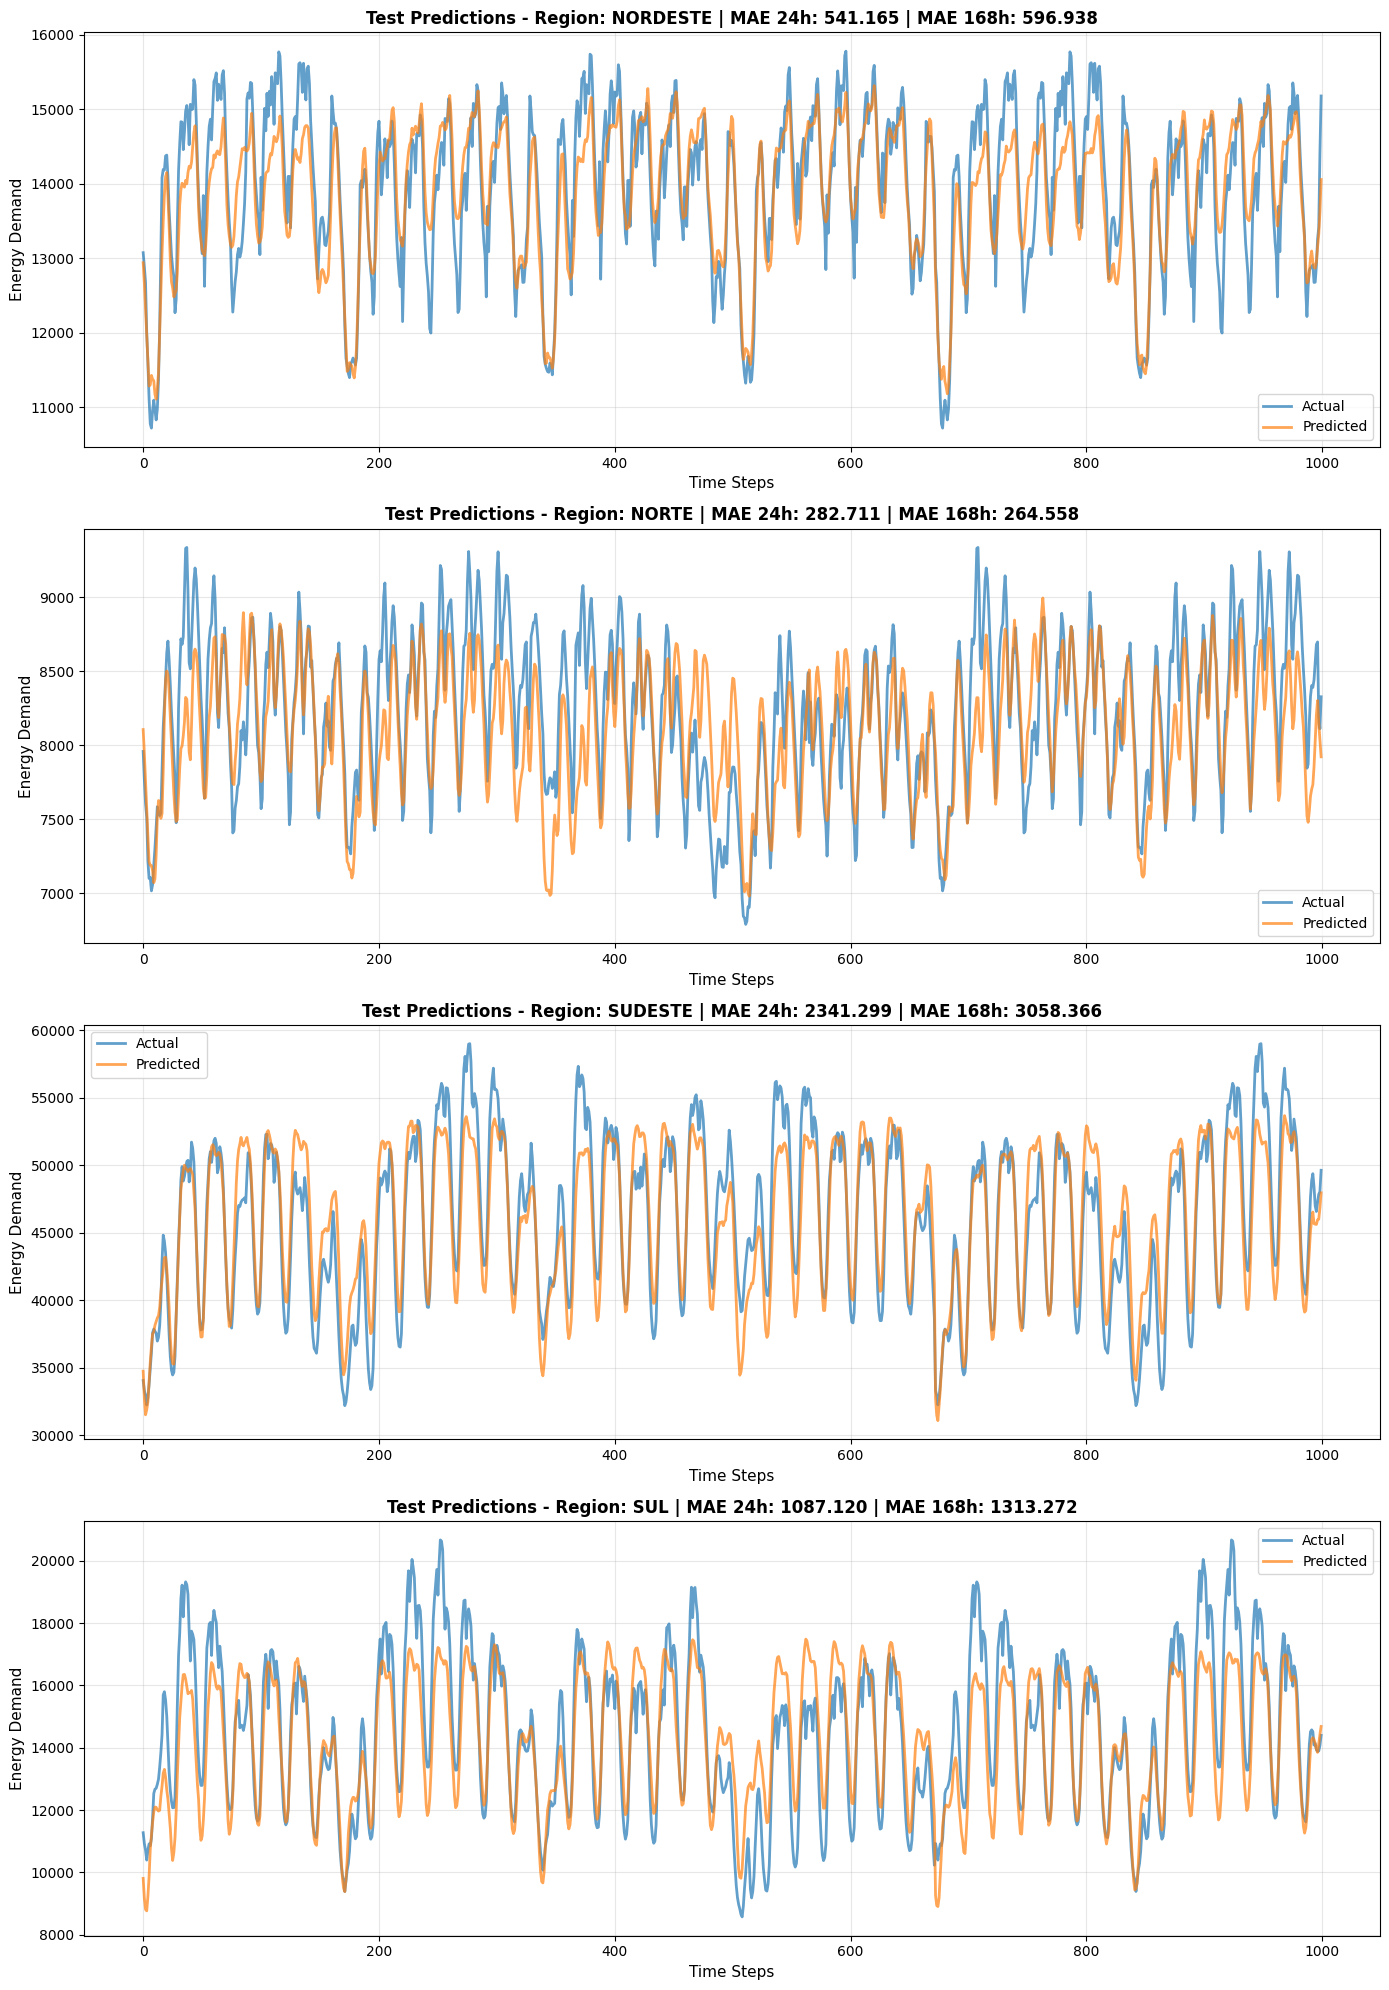

Metrics comparison saved to: /content/drive/MyDrive/Electricity_Demand_Forecast/lstm_baseline_results\metrics_comparison.png


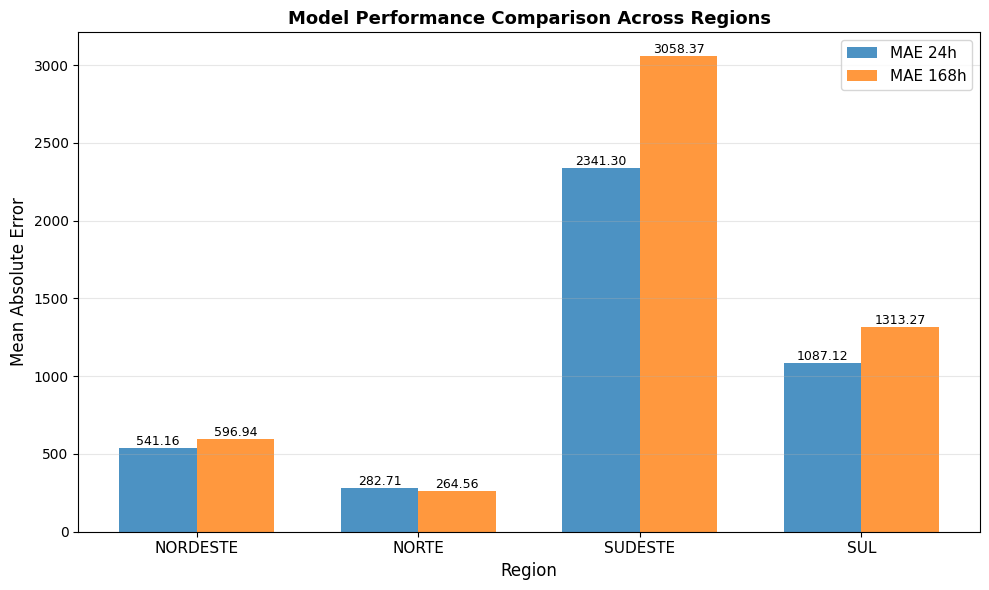

In [82]:
plot_all_results(added_feat_results)

In [21]:
models_to_fine_tune=[]

best_model_dir=[os.path.join(SAVE_DIR_HOURLY,'NORDESTE_best'),os.path.join(SAVE_DIR_HOURLY,'NORTE_best'),
                os.path.join(SAVE_DIR_HOURLY,'SUDESTE_best'),os.path.join(SAVE_DIR_HOURLY,'SUL_best')]

for i ,r in enumerate( regions):
    df_r = df_hourly_added_features[df_hourly_added_features[REGION_COL] == r].copy()
    temp_dataset = RegionDataset(df_r, ENCODER_HOURS_HOURLY, PRED_HOURS_HOURLY, split='train')
    n_features = temp_dataset[0][0].shape[1]
    ckpt=os.path.join(best_model_dir[i],"best-epoch_added_feat.ckpt")
    model=LitLSTM.load_from_checkpoint(checkpoint_path=ckpt,map_location=DEVICE)
    model.lr=5e-6
    models_to_fine_tune.append(model)

    

In [ ]:
SAVE_DIR_FINETUNED= os.path.join(SAVE_DIR_HOURLY,"added_features_lower_lr")
MAX_EPOCHS_FINE_TUNE=150

fine_tuned_results=train_lstm_per_region(df_hourly_added_features,models=models_to_fine_tune,save_dir=SAVE_DIR_FINETUNED,encoder_len=ENCODER_HOURS_HOURLY,pred_len=PRED_HOURS_HOURLY,duration_persample=60,patience=20,num_epochs=MAX_EPOCHS_FINE_TUNE)


=== TRAINING REGION: NORDESTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 209 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NORDESTE] Test MAE 24h: 570.499, 168h: 607.574

=== TRAINING REGION: NORTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 209 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NORTE] Test MAE 24h: 291.026, 168h: 275.799

=== TRAINING REGION: SUDESTE ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 209 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[SUDESTE] Test MAE 24h: 2250.170, 168h: 2805.160

=== TRAINING REGION: SUL ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | lstm    | LSTM       | 209 K 
1 | dropout | Dropout    | 0     
2 | fc      | Sequential | 51.9 K
3 | loss_fn | MSELoss    | 0     
---------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[SUL] Test MAE 24h: 1126.581, 168h: 1290.551


: 

In [ ]:
plot_all_results(fine_tuned_results,save_dir=SAVE_DIR_FINETUNED)